<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pwd

/home/cosenza/thesis/Polyphemus


In [24]:
!git branch

  main
* sparse


Libraries installation

In [25]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [26]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [27]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [28]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [63]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_SOS = 96
DUR_EOS = 97
DUR_PAD = 98

MAX_DUR = 96

# Number of time steps per quarter note
# To get bar resolution -> RESOLUTION*4
RESOLUTION = 8 
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION*4) == 0 \
                            else length + (RESOLUTION*4-(length%(RESOLUTION*4)))


        tracks_tensors = []
        tracks_activations = []

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS
            track_tensor[:, :, 1] = DUR_PAD
            track_tensor[:, 0, 0] = DUR_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time
                
                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue
                
                track_tensor[t, notes_counter[t], 0] = note.pitch
                dur = min(MAX_DUR, note.duration)
                track_tensor[t, notes_counter[t], 1] = dur-1
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS
            track_tensor[np.arange(0, length), notes_counter, 1] = DUR_EOS
            
            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)
            
            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION*4+1, RESOLUTION*4):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION*4, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION*4]
            seq_tensor = np.copy(seq_tensor)
            seq_acts = np.copy(seq_acts)

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
            

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            # Not considering pad, sos, eos tokens
            # Not transposing drums/percussions
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[1:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_EOS)
            non_perc = seq_tensor[1:, ...]
            non_perc[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples



# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [64]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [65]:
dataset_dir = 'data/lmd_matched/Y/G/'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [66]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched/Y/G/

Current path: data/lmd_matched/Y/G/B

Current path: data/lmd_matched/Y/G/B/TRYGBID128F42A74CF

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/158bfccbf647b4c88bd98ba705fd4832.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 0
Total number of saved samples: 0

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/96b527d6b0774a59583ff83707c9012c.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 2
Number of unique files: 2
Total number of non filtered songs: 0
Total number of saved samples: 0

Current path: data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651

Preprocessing file data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651/4eb991152d72121d226c6a32f9397484.mid
Processing combination 1 of 1
File preprocessing finished. Saved samples: 155

Total number of seen files: 3
Number

In [67]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [68]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [69]:
data["seq_tensor"][0, 0]

array([[ 96,  98],
       [ 36,   0],
       [129,  97],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98],
       [130,  98]], dtype=int16)

# Model

In [76]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot_p = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot_p[np.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to one-hot (dur)
        durs = seq_tensor[:, :, :, 1]
        onehot_d = np.zeros((durs.shape[0]*durs.shape[1]*durs.shape[2],
                            99), dtype=float)
        onehot_d[np.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        onehot_d = onehot_d.reshape(-1, durs.shape[1], seq_tensor.shape[2], 99)
        #bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]
        
        
        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot_p, onehot_d),
                             axis=-1)
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [99]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=230, d_transf=256, nhead_transf=4, 
                 num_layers_transf=4, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=230, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=4, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, d_token)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [107]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_p = nn.CrossEntropyLoss(ignore_index=130)
        self.ce_d = nn.CrossEntropyLoss(ignore_index=98)
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss and filter silences
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
                
        # Compute the losses
        
        #acts_loss = self.bce_unreduced(acts_rec.view(-1), x_acts.view(-1).float())
        #weights = torch.zeros(acts_loss.size()).to(device)
        #weights[x_acts.view(-1) == 1] = 0.9
        #weights[x_acts.view(-1) == 0] = 0.1
        #acts_loss = 50 * torch.mean(weights*acts_loss)
        
        pitches_loss = self.ce_p(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        dur_loss = self.ce_d(seq_rec.reshape(-1, seq_rec.size(-1))[:, 131:],
                          x_seq.reshape(-1, x_seq.size(-1))[:, 131:].argmax(dim=1))
        #dur_loss = mask * dur_loss
        #dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss# + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            #'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        #acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            #'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        #print(pitches_rec)
        
        mask_p = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask_p)
        
        
        dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)
        dur_true = torch.argmax(x_seq[..., 131:], dim=-1)
        
        print(torch.all(dur_rec == 97))
        
        mask_d = (dur_true != 98)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_dur = (dur_rec == dur_true)
        preds_dur = torch.logical_and(preds_dur, mask_d)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask_p)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        print(torch.all(acts_rec == 0))
        print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        dur_rec = F.softmax(seq_rec[..., 131:], dim=-1)
        dur_rec = torch.argmax(dur_rec, dim=-1)
        dur_true = torch.argmax(x_seq[..., 131:], dim=-1)
        
        mask = (dur_true != 98)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_dur = (dur_rec == dur_true)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [108]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [109]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

4077

In [110]:
dataset[1][0].size()

torch.Size([4, 32, 16, 230])

In [111]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [20]:
!rm models/vae

rm: cannot remove ‘models/vae’: No such file or directory


In [112]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [ ]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='oh_oh',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   58880    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.26
Losses:
{'tot': 9.783262252807617, 'pitches': 4.7482099533081055, 'dur': 5.035052299499512, 'rec': 9.783262252807617, 'kld': 1670.64208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.02442748099565506, 'dur': 0.0}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.48
Losses:
{'tot': 9.735998153686523, 'pitches': 4.7265191078186035, 'dur': 5.009478569030762, 'rec': 9.735998153686523, 'kld': 1676.4705810546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.019844694063067436, 'dur': 0.0008628127980045974}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 1/100 complete.
Elapsed 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.00
Losses:
{'tot': 8.223187446594238, 'pitches': 4.112122535705566, 'dur': 4.111064910888672, 'rec': 8.223187446594238, 'kld': 1772.851806640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.4126738905906677, 'dur': 0.05718701705336571}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.25
Losses:
{'tot': 8.013915061950684, 'pitches': 4.022943019866943, 'dur': 3.9909720420837402, 'rec': 8.013915061950684, 'kld': 1782.879638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0022539442870765924, 'pitches': 0.40871524810791016, 'dur': 0.03456047922372818}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 22/128 o

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:09.36
Losses:
{'tot': 6.967729091644287, 'pitches': 3.649101972579956, 'dur': 3.318627119064331, 'rec': 6.967729091644287, 'kld': 1946.3699951171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30312034487724304, 'pitches': 0.41010400652885437, 'dur': 0.4695393741130829}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:09.60
Losses:
{'tot': 6.906461715698242, 'pitches': 3.6211445331573486, 'dur': 3.2853174209594727, 'rec': 6.906461715698242, 'kld': 1950.514404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37360334396362305, 'pitches': 0.4036312997341156, 'dur': 0.44343575835227966}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:13.90
Losses:
{'tot': 6.1964569091796875, 'pitches': 3.38927960395813, 'dur': 2.8071773052215576, 'rec': 6.1964569091796875, 'kld': 2102.10693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41371840238571167, 'pitches': 0.41444042325019836, 'dur': 0.42527076601982117}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:14.15
Losses:
{'tot': 6.082545280456543, 'pitches': 3.4150683879852295, 'dur': 2.6674768924713135, 'rec': 6.082545280456543, 'kld': 2102.5791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4126870930194855, 'pitches': 0.4126870930194855, 'dur': 0.42337846755981445}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:18.35
Losses:
{'tot': 5.710726261138916, 'pitches': 3.2494146823883057, 'dur': 2.4613115787506104, 'rec': 5.710726261138916, 'kld': 2194.32080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4029850661754608, 'pitches': 0.412411630153656, 'dur': 0.43440690636634827}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:18.59
Losses:
{'tot': 5.603024005889893, 'pitches': 3.254415512084961, 'dur': 2.3486084938049316, 'rec': 5.603024005889893, 'kld': 2198.51123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4096848666667938, 'pitches': 0.415833979845047, 'dur': 0.44504228234291077}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:22.67
Losses:
{'tot': 5.468789100646973, 'pitches': 3.1654467582702637, 'dur': 2.30334210395813, 'rec': 5.468789100646973, 'kld': 2239.3173828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.39750584959983826, 'pitches': 0.4091971814632416, 'dur': 0.5307872295379639}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:22.91
Losses:
{'tot': 5.338425636291504, 'pitches': 3.1149468421936035, 'dur': 2.2234790325164795, 'rec': 5.338425636291504, 'kld': 2242.33837890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41601255536079407, 'pitches': 0.4199371933937073, 'dur': 0.5761381387710571}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:27.53
Losses:
{'tot': 5.282297134399414, 'pitches': 3.0749869346618652, 'dur': 2.2073099613189697, 'rec': 5.282297134399414, 'kld': 2245.6474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.37037035822868347, 'pitches': 0.4178895950317383, 'dur': 0.5779175162315369}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:27.76
Losses:
{'tot': 5.186585426330566, 'pitches': 3.0274579524993896, 'dur': 2.159127712249756, 'rec': 5.186585426330566, 'kld': 2246.54296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.40446096658706665, 'pitches': 0.41263940930366516, 'dur': 0.6171003580093384}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:31.98
Losses:
{'tot': 5.132861137390137, 'pitches': 3.078115224838257, 'dur': 2.054746150970459, 'rec': 5.132861137390137, 'kld': 2232.938232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4000000059604645, 'pitches': 0.41287878155708313, 'dur': 0.6393939256668091}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:32.22
Losses:
{'tot': 5.02492618560791, 'pitches': 3.0107531547546387, 'dur': 2.0141727924346924, 'rec': 5.02492618560791, 'kld': 2234.645751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3953147828578949, 'pitches': 0.4150805175304413, 'dur': 0.6083455085754395}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/12

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:36.33
Losses:
{'tot': 4.949894905090332, 'pitches': 2.9296340942382812, 'dur': 2.0202605724334717, 'rec': 4.949894905090332, 'kld': 2221.30078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4135936498641968, 'pitches': 0.4135936498641968, 'dur': 0.6326825618743896}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:36.58
Losses:
{'tot': 4.914397239685059, 'pitches': 2.9220194816589355, 'dur': 1.992377758026123, 'rec': 4.914397239685059, 'kld': 2223.94287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.40591806173324585, 'pitches': 0.41350531578063965, 'dur': 0.6305007338523865}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.73
Losses:
{'tot': 4.843489170074463, 'pitches': 2.9356696605682373, 'dur': 1.907819390296936, 'rec': 4.843489170074463, 'kld': 2199.3369140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.39594972133636475, 'pitches': 0.40502792596817017, 'dur': 0.6382681727409363}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.98
Losses:
{'tot': 4.805715560913086, 'pitches': 2.94697642326355, 'dur': 1.8587392568588257, 'rec': 4.805715560913086, 'kld': 2198.326416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.40554338693618774, 'pitches': 0.4062727987766266, 'dur': 0.6513493657112122}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.09
Losses:
{'tot': 4.7173895835876465, 'pitches': 2.79258394241333, 'dur': 1.9248055219650269, 'rec': 4.7173895835876465, 'kld': 2176.25341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41004183888435364, 'pitches': 0.41004183888435364, 'dur': 0.6259413957595825}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.32
Losses:
{'tot': 4.80781888961792, 'pitches': 2.954869270324707, 'dur': 1.852949619293213, 'rec': 4.80781888961792, 'kld': 2172.8642578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.40764790773391724, 'pitches': 0.40764790773391724, 'dur': 0.6341991424560547}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:49.93
Losses:
{'tot': 4.691859722137451, 'pitches': 2.894469976425171, 'dur': 1.7973897457122803, 'rec': 4.691859722137451, 'kld': 2153.14892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.42296919226646423, 'pitches': 0.42296919226646423, 'dur': 0.6358543634414673}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:50.19
Losses:
{'tot': 4.700335502624512, 'pitches': 2.952392101287842, 'dur': 1.747943639755249, 'rec': 4.700335502624512, 'kld': 2148.238037109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4076738655567169, 'pitches': 0.4076738655567169, 'dur': 0.6314948201179504}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:54.85
Losses:
{'tot': 4.639385223388672, 'pitches': 2.796035051345825, 'dur': 1.8433499336242676, 'rec': 4.639385223388672, 'kld': 2141.480224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4375, 'pitches': 0.44086021184921265, 'dur': 0.625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:55.07
Losses:
{'tot': 4.362420558929443, 'pitches': 2.6682605743408203, 'dur': 1.694159984588623, 'rec': 4.362420558929443, 'kld': 2139.50927734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46203553676605225, 'pitches': 0.46203553676605225, 'dur': 0.6615508794784546}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 2/100

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:59.31
Losses:
{'tot': 4.55679178237915, 'pitches': 2.8569672107696533, 'dur': 1.699824571609497, 'rec': 4.55679178237915, 'kld': 2138.30712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4534967541694641, 'pitches': 0.4534967541694641, 'dur': 0.6532083749771118}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:59.55
Losses:
{'tot': 4.507544040679932, 'pitches': 2.770064353942871, 'dur': 1.73747980594635, 'rec': 4.507544040679932, 'kld': 2140.135498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4599125385284424, 'pitches': 0.46064141392707825, 'dur': 0.6428571343421936}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:03.81
Losses:
{'tot': 4.597115516662598, 'pitches': 2.7222793102264404, 'dur': 1.8748364448547363, 'rec': 4.597115516662598, 'kld': 2138.717041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47255370020866394, 'pitches': 0.47255370020866394, 'dur': 0.6157518029212952}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:01:03.94
Losses:
{'tot': 4.456463813781738, 'pitches': 2.608563184738159, 'dur': 1.847900390625, 'rec': 4.456463813781738, 'kld': 869.5535278320312, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4716311991214752, 'pitches': 0.4716311991214752, 'dur': 0.6028369069099426}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.19
Losses:
{'tot': 4.1745758056640625, 'pitches': 2.623866081237793, 'dur': 1.5507094860076904, 'rec': 4.1745758056640625, 'kld': 2142.0703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.475996732711792, 'pitches': 0.4792514145374298, 'dur': 0.6802278161048889}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.43
Losses:
{'tot': 4.402915954589844, 'pitches': 2.7319138050079346, 'dur': 1.6710021495819092, 'rec': 4.402915954589844, 'kld': 2137.5703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46555474400520325, 'pitches': 0.46773025393486023, 'dur': 0.6497461795806885}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.53
Losses:
{'tot': 4.371392250061035, 'pitches': 2.677590847015381, 'dur': 1.6938014030456543, 'rec': 4.371392250061035, 'kld': 2144.93408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46856287121772766, 'pitches': 0.47455090284347534, 'dur': 0.6459580659866333}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.76
Losses:
{'tot': 4.378587245941162, 'pitches': 2.6613593101501465, 'dur': 1.7172280550003052, 'rec': 4.378587245941162, 'kld': 2148.0478515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4671151041984558, 'pitches': 0.4693572521209717, 'dur': 0.6360239386558533}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:12.92
Losses:
{'tot': 4.268567085266113, 'pitches': 2.583350419998169, 'dur': 1.6852166652679443, 'rec': 4.268567085266113, 'kld': 2156.044189453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47852760553359985, 'pitches': 0.4811568856239319, 'dur': 0.657318115234375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:13.16
Losses:
{'tot': 4.446403980255127, 'pitches': 2.6709511280059814, 'dur': 1.775452971458435, 'rec': 4.446403980255127, 'kld': 2153.924072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4648187756538391, 'pitches': 0.4662402272224426, 'dur': 0.6112295389175415}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:17.79
Losses:
{'tot': 4.196257591247559, 'pitches': 2.596190929412842, 'dur': 1.6000666618347168, 'rec': 4.196257591247559, 'kld': 2164.07958984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46403712034225464, 'pitches': 0.46790409088134766, 'dur': 0.6442382335662842}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:18.04
Losses:
{'tot': 4.293510913848877, 'pitches': 2.6843035221099854, 'dur': 1.6092075109481812, 'rec': 4.293510913848877, 'kld': 2162.392578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46438172459602356, 'pitches': 0.46438172459602356, 'dur': 0.6384408473968506}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:22.14
Losses:
{'tot': 4.3338823318481445, 'pitches': 2.66972017288208, 'dur': 1.664162278175354, 'rec': 4.3338823318481445, 'kld': 2169.73583984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46069180965423584, 'pitches': 0.46226415038108826, 'dur': 0.6391509175300598}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:22.39
Losses:
{'tot': 4.2754950523376465, 'pitches': 2.603239059448242, 'dur': 1.6722558736801147, 'rec': 4.2754950523376465, 'kld': 2169.234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4757152497768402, 'pitches': 0.4777112305164337, 'dur': 0.6280771493911743}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:26.77
Losses:
{'tot': 4.253261089324951, 'pitches': 2.5929412841796875, 'dur': 1.6603199243545532, 'rec': 4.253261089324951, 'kld': 2176.22998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4595237970352173, 'pitches': 0.4642857015132904, 'dur': 0.6309523582458496}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:27.01
Losses:
{'tot': 4.237245082855225, 'pitches': 2.5924742221832275, 'dur': 1.644770860671997, 'rec': 4.237245082855225, 'kld': 2178.576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46010440587997437, 'pitches': 0.468307226896286, 'dur': 0.636092483997345}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:31.22
Losses:
{'tot': 4.071949005126953, 'pitches': 2.490135431289673, 'dur': 1.5818138122558594, 'rec': 4.071949005126953, 'kld': 2178.83984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.480369508266449, 'pitches': 0.4849884510040283, 'dur': 0.6443418264389038}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:31.46
Losses:
{'tot': 4.2823920249938965, 'pitches': 2.648350715637207, 'dur': 1.634041428565979, 'rec': 4.2823920249938965, 'kld': 2174.658935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4677419364452362, 'pitches': 0.4706744849681854, 'dur': 0.650293231010437}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:35.64
Losses:
{'tot': 4.286703586578369, 'pitches': 2.6483967304229736, 'dur': 1.638306736946106, 'rec': 4.286703586578369, 'kld': 2179.19287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44057971239089966, 'pitches': 0.44565218687057495, 'dur': 0.6326087117195129}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:35.76
Losses:
{'tot': 4.072787284851074, 'pitches': 2.526169538497925, 'dur': 1.5466176271438599, 'rec': 4.072787284851074, 'kld': 889.1343994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47654783725738525, 'pitches': 0.4784240126609802, 'dur': 0.6660412549972534}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:36.01
Losses:
{'tot': 4.230158805847168, 'pitches': 2.633087396621704, 'dur': 1.5970712900161743, 'rec': 4.230158805847168, 'kld': 2188.119140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4722662568092346, 'pitches': 0.4762282073497772, 'dur': 0.6600633859634399}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:36.26
Losses:
{'tot': 4.178681373596191, 'pitches': 2.7077057361602783, 'dur': 1.470975399017334, 'rec': 4.178681373596191, 'kld': 2183.08984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45672333240509033, 'pitches': 0.45749613642692566, 'dur': 0.687017023563385}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:40.92
Losses:
{'tot': 4.204155445098877, 'pitches': 2.615586519241333, 'dur': 1.588568925857544, 'rec': 4.204155445098877, 'kld': 2196.68212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4544179439544678, 'pitches': 0.45652174949645996, 'dur': 0.6521739363670349}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:41.16
Losses:
{'tot': 4.212719917297363, 'pitches': 2.6766974925994873, 'dur': 1.5360221862792969, 'rec': 4.212719917297363, 'kld': 2199.08740234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44798657298088074, 'pitches': 0.449664443731308, 'dur': 0.6652684807777405}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:45.35
Losses:
{'tot': 3.8795220851898193, 'pitches': 2.449418544769287, 'dur': 1.4301035404205322, 'rec': 3.8795220851898193, 'kld': 2211.322021484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48547402024269104, 'pitches': 0.48929664492607117, 'dur': 0.6857798099517822}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:45.62
Losses:
{'tot': 4.189767837524414, 'pitches': 2.6178476810455322, 'dur': 1.5719201564788818, 'rec': 4.189767837524414, 'kld': 2209.67578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4545454680919647, 'pitches': 0.4581245481967926, 'dur': 0.6642805933952332}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:49.91
Losses:
{'tot': 4.0406599044799805, 'pitches': 2.5662038326263428, 'dur': 1.4744563102722168, 'rec': 4.0406599044799805, 'kld': 2216.236328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4694024622440338, 'pitches': 0.4744420349597931, 'dur': 0.6904247403144836}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:50.15
Losses:
{'tot': 3.935556650161743, 'pitches': 2.442821741104126, 'dur': 1.4927349090576172, 'rec': 3.935556650161743, 'kld': 2210.57275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45723962783813477, 'pitches': 0.45893311500549316, 'dur': 0.701100766658783}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:54.29
Losses:
{'tot': 4.015765190124512, 'pitches': 2.425832986831665, 'dur': 1.5899319648742676, 'rec': 4.015765190124512, 'kld': 2218.55029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47119998931884766, 'pitches': 0.47920000553131104, 'dur': 0.6639999747276306}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:54.54
Losses:
{'tot': 3.8873419761657715, 'pitches': 2.3809359073638916, 'dur': 1.5064060688018799, 'rec': 3.8873419761657715, 'kld': 2224.89111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48099416494369507, 'pitches': 0.48903509974479675, 'dur': 0.6790935397148132}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:58.69
Losses:
{'tot': 4.090165615081787, 'pitches': 2.583834409713745, 'dur': 1.5063310861587524, 'rec': 4.090165615081787, 'kld': 2235.467041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4570765793323517, 'pitches': 0.4671306908130646, 'dur': 0.689095139503479}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:58.93
Losses:
{'tot': 4.016410827636719, 'pitches': 2.547785997390747, 'dur': 1.4686249494552612, 'rec': 4.016410827636719, 'kld': 2237.44970703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46020761132240295, 'pitches': 0.4657439589500427, 'dur': 0.6948096752166748}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:03.15
Losses:
{'tot': 3.8611550331115723, 'pitches': 2.452198028564453, 'dur': 1.4089571237564087, 'rec': 3.8611550331115723, 'kld': 2253.24072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47050148248672485, 'pitches': 0.47787609696388245, 'dur': 0.7116519212722778}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:03.40
Losses:
{'tot': 3.984768867492676, 'pitches': 2.5040981769561768, 'dur': 1.480670690536499, 'rec': 3.984768867492676, 'kld': 2250.51708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46773073077201843, 'pitches': 0.4781401753425598, 'dur': 0.7078417539596558}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:08.11
Losses:
{'tot': 3.975437641143799, 'pitches': 2.543520212173462, 'dur': 1.4319173097610474, 'rec': 3.975437641143799, 'kld': 2260.3203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4679572880268097, 'pitches': 0.4753004014492035, 'dur': 0.7062750458717346}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:02:08.26
Losses:
{'tot': 4.19617223739624, 'pitches': 2.644059896469116, 'dur': 1.552112340927124, 'rec': 4.19617223739624, 'kld': 917.9320068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4527629315853119, 'pitches': 0.4688057005405426, 'dur': 0.6684492230415344}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:08.51
Losses:
{'tot': 3.778256416320801, 'pitches': 2.491827964782715, 'dur': 1.2864285707473755, 'rec': 3.778256416320801, 'kld': 2258.17919921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48148149251937866, 'pitches': 0.48456791043281555, 'dur': 0.7361111044883728}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:08.76
Losses:
{'tot': 3.9193854331970215, 'pitches': 2.5343551635742188, 'dur': 1.3850303888320923, 'rec': 3.9193854331970215, 'kld': 2256.359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47940075397491455, 'pitches': 0.4913857579231262, 'dur': 0.7265917658805847}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:13.02
Losses:
{'tot': 3.891451835632324, 'pitches': 2.445504665374756, 'dur': 1.4459471702575684, 'rec': 3.891451835632324, 'kld': 2270.10498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48050975799560547, 'pitches': 0.48725637793540955, 'dur': 0.691154420375824}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:13.27
Losses:
{'tot': 3.9598183631896973, 'pitches': 2.554835319519043, 'dur': 1.4049830436706543, 'rec': 3.9598183631896973, 'kld': 2271.19921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46520423889160156, 'pitches': 0.4886535406112671, 'dur': 0.7133131623268127}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:17.46
Losses:
{'tot': 3.9060912132263184, 'pitches': 2.4899189472198486, 'dur': 1.4161722660064697, 'rec': 3.9060912132263184, 'kld': 2272.3251953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49347975850105286, 'pitches': 0.5010294914245605, 'dur': 0.7062457203865051}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:17.70
Losses:
{'tot': 4.047278881072998, 'pitches': 2.5423219203948975, 'dur': 1.5049570798873901, 'rec': 4.047278881072998, 'kld': 2276.2490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4661538600921631, 'pitches': 0.48461538553237915, 'dur': 0.6753846406936646}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:21.95
Losses:
{'tot': 3.534311294555664, 'pitches': 2.278933525085449, 'dur': 1.2553777694702148, 'rec': 3.534311294555664, 'kld': 2273.517822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5351201295852661, 'pitches': 0.5425138473510742, 'dur': 0.7513863444328308}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:22.18
Losses:
{'tot': 3.7414557933807373, 'pitches': 2.3795197010040283, 'dur': 1.361936092376709, 'rec': 3.7414557933807373, 'kld': 2279.5966796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5226781964302063, 'pitches': 0.5241180658340454, 'dur': 0.730741560459137}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:26.34
Losses:
{'tot': 3.5491576194763184, 'pitches': 2.233584403991699, 'dur': 1.3155732154846191, 'rec': 3.5491576194763184, 'kld': 2295.8603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5438108444213867, 'pitches': 0.5479832887649536, 'dur': 0.7093185186386108}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:26.59
Losses:
{'tot': 3.999638080596924, 'pitches': 2.550931692123413, 'dur': 1.4487065076828003, 'rec': 3.999638080596924, 'kld': 2291.418701171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4854586124420166, 'pitches': 0.4973900020122528, 'dur': 0.6853094696998596}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:31.39
Losses:
{'tot': 3.5493016242980957, 'pitches': 2.3234453201293945, 'dur': 1.2258563041687012, 'rec': 3.5493016242980957, 'kld': 2315.714111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5251798629760742, 'pitches': 0.5359712243080139, 'dur': 0.7417266368865967}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:31.64
Losses:
{'tot': 3.6739110946655273, 'pitches': 2.3339931964874268, 'dur': 1.3399180173873901, 'rec': 3.6739110946655273, 'kld': 2313.9375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5298507213592529, 'pitches': 0.532835841178894, 'dur': 0.7268656492233276}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 9

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:35.80
Losses:
{'tot': 3.699151039123535, 'pitches': 2.433155059814453, 'dur': 1.265995979309082, 'rec': 3.699151039123535, 'kld': 2330.609619140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.52589350938797, 'pitches': 0.529540479183197, 'dur': 0.7396061420440674}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:36.06
Losses:
{'tot': 3.573157787322998, 'pitches': 2.261164426803589, 'dur': 1.3119933605194092, 'rec': 3.573157787322998, 'kld': 2331.871826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5423606038093567, 'pitches': 0.5517740845680237, 'dur': 0.720492422580719}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:40.14
Losses:
{'tot': 3.761239767074585, 'pitches': 2.428084373474121, 'dur': 1.3331553936004639, 'rec': 3.761239767074585, 'kld': 2337.362060546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4964871108531952, 'pitches': 0.5066354274749756, 'dur': 0.7236533761024475}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:40.29
Losses:
{'tot': 3.7105331420898438, 'pitches': 2.5205612182617188, 'dur': 1.1899718046188354, 'rec': 3.7105331420898438, 'kld': 950.9935302734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4631783068180084, 'pitches': 0.49031007289886475, 'dur': 0.7577519416809082}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:40.56
Losses:
{'tot': 3.7072396278381348, 'pitches': 2.3895580768585205, 'dur': 1.3176814317703247, 'rec': 3.7072396278381348, 'kld': 2342.20849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5143288373947144, 'pitches': 0.5188537240028381, 'dur': 0.7187028527259827}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:40.81
Losses:
{'tot': 3.697610855102539, 'pitches': 2.397594690322876, 'dur': 1.300016164779663, 'rec': 3.697610855102539, 'kld': 2340.15185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5084996223449707, 'pitches': 0.5099778175354004, 'dur': 0.7450110912322998}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:44.93
Losses:
{'tot': 3.5922012329101562, 'pitches': 2.361298084259033, 'dur': 1.2309030294418335, 'rec': 3.5922012329101562, 'kld': 2345.7802734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5298149585723877, 'pitches': 0.5318711400032043, 'dur': 0.7457162737846375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:45.16
Losses:
{'tot': 3.653414726257324, 'pitches': 2.385465383529663, 'dur': 1.2679492235183716, 'rec': 3.653414726257324, 'kld': 2337.91650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5192307829856873, 'pitches': 0.5280448794364929, 'dur': 0.7307692170143127}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:49.30
Losses:
{'tot': 3.8462586402893066, 'pitches': 2.453598737716675, 'dur': 1.3926597833633423, 'rec': 3.8462586402893066, 'kld': 2354.16650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5125240683555603, 'pitches': 0.5150931477546692, 'dur': 0.7052023410797119}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:49.54
Losses:
{'tot': 3.6875951290130615, 'pitches': 2.3908634185791016, 'dur': 1.29673171043396, 'rec': 3.6875951290130615, 'kld': 2355.30419921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5262807607650757, 'pitches': 0.5302727818489075, 'dur': 0.7365269660949707}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:53.75
Losses:
{'tot': 3.6121153831481934, 'pitches': 2.3818867206573486, 'dur': 1.2302287817001343, 'rec': 3.6121153831481934, 'kld': 2364.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5087209343910217, 'pitches': 0.510901153087616, 'dur': 0.7354651093482971}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:53.98
Losses:
{'tot': 3.447176694869995, 'pitches': 2.288935661315918, 'dur': 1.1582410335540771, 'rec': 3.447176694869995, 'kld': 2368.185791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5329471230506897, 'pitches': 0.540912389755249, 'dur': 0.7545257210731506}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:58.77
Losses:
{'tot': 3.655414581298828, 'pitches': 2.3676538467407227, 'dur': 1.2877607345581055, 'rec': 3.655414581298828, 'kld': 2378.4052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5230987668037415, 'pitches': 0.526652455329895, 'dur': 0.7164179086685181}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:59.02
Losses:
{'tot': 4.00451135635376, 'pitches': 2.567600965499878, 'dur': 1.4369105100631714, 'rec': 4.00451135635376, 'kld': 2371.514404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47628459334373474, 'pitches': 0.47694334387779236, 'dur': 0.7048748135566711}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:03.26
Losses:
{'tot': 3.8268380165100098, 'pitches': 2.4755539894104004, 'dur': 1.3512840270996094, 'rec': 3.8268380165100098, 'kld': 2392.857421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.495708167552948, 'pitches': 0.497854083776474, 'dur': 0.7188841104507446}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:03.50
Losses:
{'tot': 3.5006468296051025, 'pitches': 2.3009655475616455, 'dur': 1.199681282043457, 'rec': 3.5006468296051025, 'kld': 2391.123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5180451273918152, 'pitches': 0.523308277130127, 'dur': 0.7488721609115601}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:07.70
Losses:
{'tot': 3.7745442390441895, 'pitches': 2.4712841510772705, 'dur': 1.3032602071762085, 'rec': 3.7745442390441895, 'kld': 2406.161376953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.499194860458374, 'pitches': 0.5024154782295227, 'dur': 0.7254428267478943}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:07.96
Losses:
{'tot': 3.531148910522461, 'pitches': 2.3232619762420654, 'dur': 1.207886815071106, 'rec': 3.531148910522461, 'kld': 2403.376220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5185714364051819, 'pitches': 0.520714282989502, 'dur': 0.7378571629524231}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:12.13
Losses:
{'tot': 3.4693636894226074, 'pitches': 2.324042320251465, 'dur': 1.145321249961853, 'rec': 3.4693636894226074, 'kld': 2415.67041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5220534801483154, 'pitches': 0.527114987373352, 'dur': 0.7302964329719543}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:03:12.27
Losses:
{'tot': 3.960705518722534, 'pitches': 2.5783820152282715, 'dur': 1.3823235034942627, 'rec': 3.960705518722534, 'kld': 976.0181884765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4701130986213684, 'pitches': 0.4733441174030304, 'dur': 0.6688206791877747}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:12.52
Losses:
{'tot': 3.412123441696167, 'pitches': 2.2340738773345947, 'dur': 1.1780495643615723, 'rec': 3.412123441696167, 'kld': 2410.690673828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5302663445472717, 'pitches': 0.5359160900115967, 'dur': 0.7457627058029175}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:12.77
Losses:
{'tot': 3.6641628742218018, 'pitches': 2.461085557937622, 'dur': 1.2030773162841797, 'rec': 3.6641628742218018, 'kld': 2413.294921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47063252329826355, 'pitches': 0.47665661573410034, 'dur': 0.7146084308624268}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:16.91
Losses:
{'tot': 3.581139087677002, 'pitches': 2.369382619857788, 'dur': 1.2117564678192139, 'rec': 3.581139087677002, 'kld': 2417.564208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5176803469657898, 'pitches': 0.5261669158935547, 'dur': 0.7312588691711426}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:17.16
Losses:
{'tot': 3.7915189266204834, 'pitches': 2.530144453048706, 'dur': 1.2613744735717773, 'rec': 3.7915189266204834, 'kld': 2411.494140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48195329308509827, 'pitches': 0.4911535680294037, 'dur': 0.7077140808105469}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:21.82
Losses:
{'tot': 3.465611696243286, 'pitches': 2.2730894088745117, 'dur': 1.1925222873687744, 'rec': 3.465611696243286, 'kld': 2426.45068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5376505851745605, 'pitches': 0.5421686768531799, 'dur': 0.7432228922843933}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:22.08
Losses:
{'tot': 3.449033737182617, 'pitches': 2.2572011947631836, 'dur': 1.191832423210144, 'rec': 3.449033737182617, 'kld': 2429.070556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5275481939315796, 'pitches': 0.5371900796890259, 'dur': 0.7348484992980957}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:26.31
Losses:
{'tot': 3.632340669631958, 'pitches': 2.369349956512451, 'dur': 1.2629907131195068, 'rec': 3.632340669631958, 'kld': 2438.3193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5246953368186951, 'pitches': 0.5246953368186951, 'dur': 0.7100705504417419}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:26.57
Losses:
{'tot': 3.6119518280029297, 'pitches': 2.2735464572906494, 'dur': 1.3384054899215698, 'rec': 3.6119518280029297, 'kld': 2437.60205078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5319617986679077, 'pitches': 0.5378398299217224, 'dur': 0.7193240523338318}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:30.71
Losses:
{'tot': 3.415351152420044, 'pitches': 2.2730283737182617, 'dur': 1.1423227787017822, 'rec': 3.415351152420044, 'kld': 2441.940185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5242399573326111, 'pitches': 0.5299918055534363, 'dur': 0.7526705265045166}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:30.95
Losses:
{'tot': 3.6536405086517334, 'pitches': 2.393131971359253, 'dur': 1.2605085372924805, 'rec': 3.6536405086517334, 'kld': 2445.353271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5071806311607361, 'pitches': 0.509448230266571, 'dur': 0.7248677015304565}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:34.99
Losses:
{'tot': 3.572488784790039, 'pitches': 2.3096554279327393, 'dur': 1.2628334760665894, 'rec': 3.572488784790039, 'kld': 2459.02734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5242984294891357, 'pitches': 0.5242984294891357, 'dur': 0.7227926254272461}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:35.23
Losses:
{'tot': 3.605081081390381, 'pitches': 2.356912612915039, 'dur': 1.2481685876846313, 'rec': 3.605081081390381, 'kld': 2461.25927734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.502637505531311, 'pitches': 0.5094197392463684, 'dur': 0.6948003172874451}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:39.17
Losses:
{'tot': 3.4402236938476562, 'pitches': 2.214189291000366, 'dur': 1.2260345220565796, 'rec': 3.4402236938476562, 'kld': 2475.2197265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5408950448036194, 'pitches': 0.5462962985038757, 'dur': 0.729938268661499}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:39.40
Losses:
{'tot': 3.433269500732422, 'pitches': 2.2732183933258057, 'dur': 1.1600509881973267, 'rec': 3.433269500732422, 'kld': 2472.990966796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5216400623321533, 'pitches': 0.5261958837509155, 'dur': 0.7479119300842285}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:43.58
Losses:
{'tot': 3.3373923301696777, 'pitches': 2.1680634021759033, 'dur': 1.169329047203064, 'rec': 3.3373923301696777, 'kld': 2480.762451171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5378788113594055, 'pitches': 0.5420875549316406, 'dur': 0.744107723236084}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:43.71
Losses:
{'tot': 3.5762641429901123, 'pitches': 2.3954806327819824, 'dur': 1.1807835102081299, 'rec': 3.5762641429901123, 'kld': 1008.3937377929688, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49275362491607666, 'pitches': 0.49275362491607666, 'dur': 0.7660455703735352}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:43.99
Losses:
{'tot': 3.4646992683410645, 'pitches': 2.293766736984253, 'dur': 1.170932650566101, 'rec': 3.4646992683410645, 'kld': 2480.333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5137255191802979, 'pitches': 0.5168627500534058, 'dur': 0.7419607639312744}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:44.25
Losses:
{'tot': 3.5926928520202637, 'pitches': 2.3514838218688965, 'dur': 1.2412090301513672, 'rec': 3.5926928520202637, 'kld': 2474.71875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5064935088157654, 'pitches': 0.5101010203361511, 'dur': 0.7294372320175171}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:48.94
Losses:
{'tot': 3.64501690864563, 'pitches': 2.3443973064422607, 'dur': 1.3006196022033691, 'rec': 3.64501690864563, 'kld': 2486.0078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5189263820648193, 'pitches': 0.5230557322502136, 'dur': 0.7302133440971375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:49.18
Losses:
{'tot': 3.3849425315856934, 'pitches': 2.218325614929199, 'dur': 1.1666169166564941, 'rec': 3.3849425315856934, 'kld': 2486.42578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5448079705238342, 'pitches': 0.5462304353713989, 'dur': 0.7339971661567688}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:53.37
Losses:
{'tot': 3.410335063934326, 'pitches': 2.2547101974487305, 'dur': 1.1556249856948853, 'rec': 3.410335063934326, 'kld': 2491.59716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5338078141212463, 'pitches': 0.5409252643585205, 'dur': 0.7523131966590881}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:53.62
Losses:
{'tot': 3.4116530418395996, 'pitches': 2.275737762451172, 'dur': 1.1359152793884277, 'rec': 3.4116530418395996, 'kld': 2494.7529296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5182926654815674, 'pitches': 0.5297256112098694, 'dur': 0.7553353905677795}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:57.94
Losses:
{'tot': 3.4936604499816895, 'pitches': 2.295328140258789, 'dur': 1.1983321905136108, 'rec': 3.4936604499816895, 'kld': 2495.531494140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5169960260391235, 'pitches': 0.5233201384544373, 'dur': 0.739130437374115}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:58.19
Losses:
{'tot': 3.314821720123291, 'pitches': 2.124262571334839, 'dur': 1.1905590295791626, 'rec': 3.314821720123291, 'kld': 2496.190185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5637149214744568, 'pitches': 0.567314624786377, 'dur': 0.7393808364868164}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:02.36
Losses:
{'tot': 3.38167142868042, 'pitches': 2.196941375732422, 'dur': 1.1847301721572876, 'rec': 3.38167142868042, 'kld': 2502.37060546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5392670035362244, 'pitches': 0.5445026159286499, 'dur': 0.753926694393158}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:02.61
Losses:
{'tot': 3.398037910461426, 'pitches': 2.314142942428589, 'dur': 1.083894968032837, 'rec': 3.398037910461426, 'kld': 2504.0986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4974396526813507, 'pitches': 0.49890270829200745, 'dur': 0.7702999114990234}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:06.85
Losses:
{'tot': 3.5450544357299805, 'pitches': 2.304668426513672, 'dur': 1.2403860092163086, 'rec': 3.5450544357299805, 'kld': 2505.97265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5204724669456482, 'pitches': 0.5251968502998352, 'dur': 0.7440944910049438}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:07.09
Losses:
{'tot': 3.541149139404297, 'pitches': 2.3383371829986572, 'dur': 1.20281183719635, 'rec': 3.541149139404297, 'kld': 2504.37841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5058565139770508, 'pitches': 0.5102488994598389, 'dur': 0.7298682332038879}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:11.73
Losses:
{'tot': 3.727658271789551, 'pitches': 2.476490020751953, 'dur': 1.251168131828308, 'rec': 3.727658271789551, 'kld': 2506.4365234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4767199456691742, 'pitches': 0.4794996380805969, 'dur': 0.7129951119422913}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:11.96
Losses:
{'tot': 3.237614631652832, 'pitches': 2.1770517826080322, 'dur': 1.0605627298355103, 'rec': 3.237614631652832, 'kld': 2512.380126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5246913433074951, 'pitches': 0.5347222089767456, 'dur': 0.772376537322998}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:15.91
Losses:
{'tot': 3.5560784339904785, 'pitches': 2.378304958343506, 'dur': 1.177773356437683, 'rec': 3.5560784339904785, 'kld': 2514.73583984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49678340554237366, 'pitches': 0.501787006855011, 'dur': 0.7319514155387878}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:04:16.05
Losses:
{'tot': 3.3918492794036865, 'pitches': 2.1147444248199463, 'dur': 1.2771048545837402, 'rec': 3.3918492794036865, 'kld': 1021.8236083984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5591985583305359, 'pitches': 0.562841534614563, 'dur': 0.7413479089736938}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:16.33
Losses:
{'tot': 3.352339744567871, 'pitches': 2.1679983139038086, 'dur': 1.1843414306640625, 'rec': 3.352339744567871, 'kld': 2517.25146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5360744595527649, 'pitches': 0.539177656173706, 'dur': 0.7346780300140381}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:16.57
Losses:
{'tot': 3.3825674057006836, 'pitches': 2.2866599559783936, 'dur': 1.09590744972229, 'rec': 3.3825674057006836, 'kld': 2515.9111328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5011727809906006, 'pitches': 0.5035184025764465, 'dur': 0.7529319524765015}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:20.67
Losses:
{'tot': 3.4775054454803467, 'pitches': 2.2234621047973633, 'dur': 1.2540433406829834, 'rec': 3.4775054454803467, 'kld': 2522.294189453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5268965363502502, 'pitches': 0.5317241549491882, 'dur': 0.7344827651977539}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:20.91
Losses:
{'tot': 3.376241683959961, 'pitches': 2.2311909198760986, 'dur': 1.1450508832931519, 'rec': 3.376241683959961, 'kld': 2525.76708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5234493017196655, 'pitches': 0.5279878973960876, 'dur': 0.7443267703056335}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:25.06
Losses:
{'tot': 3.1434993743896484, 'pitches': 2.0123798847198486, 'dur': 1.1311196088790894, 'rec': 3.1434993743896484, 'kld': 2531.75830078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5689243078231812, 'pitches': 0.5721115469932556, 'dur': 0.7609561681747437}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:25.30
Losses:
{'tot': 3.296905040740967, 'pitches': 2.203155040740967, 'dur': 1.0937498807907104, 'rec': 3.296905040740967, 'kld': 2530.3720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5244375467300415, 'pitches': 0.5298681259155273, 'dur': 0.7680372595787048}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:29.46
Losses:
{'tot': 3.3500421047210693, 'pitches': 2.251769781112671, 'dur': 1.0982723236083984, 'rec': 3.3500421047210693, 'kld': 2532.3623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.523468554019928, 'pitches': 0.5282418727874756, 'dur': 0.7653142213821411}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:29.70
Losses:
{'tot': 3.362311840057373, 'pitches': 2.210648775100708, 'dur': 1.1516631841659546, 'rec': 3.362311840057373, 'kld': 2532.911865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5243552923202515, 'pitches': 0.5250716209411621, 'dur': 0.7686246633529663}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:33.93
Losses:
{'tot': 3.3821074962615967, 'pitches': 2.1982100009918213, 'dur': 1.1838974952697754, 'rec': 3.3821074962615967, 'kld': 2535.82666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5290456414222717, 'pitches': 0.5366528630256653, 'dur': 0.7455048561096191}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:34.17
Losses:
{'tot': 3.391073703765869, 'pitches': 2.2357661724090576, 'dur': 1.155307412147522, 'rec': 3.391073703765869, 'kld': 2528.4140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5172690749168396, 'pitches': 0.5188754796981812, 'dur': 0.7477911710739136}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:38.89
Losses:
{'tot': 3.291947364807129, 'pitches': 2.170053243637085, 'dur': 1.1218940019607544, 'rec': 3.291947364807129, 'kld': 2537.439453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5351351499557495, 'pitches': 0.5420849323272705, 'dur': 0.7413127422332764}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:39.15
Losses:
{'tot': 3.3537237644195557, 'pitches': 2.2136473655700684, 'dur': 1.1400763988494873, 'rec': 3.3537237644195557, 'kld': 2542.338134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5240963697433472, 'pitches': 0.5301204919815063, 'dur': 0.7469879388809204}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:43.40
Losses:
{'tot': 3.1449856758117676, 'pitches': 2.07423996925354, 'dur': 1.070745587348938, 'rec': 3.1449856758117676, 'kld': 2546.484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5563218593597412, 'pitches': 0.5586206912994385, 'dur': 0.7724137902259827}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:43.65
Losses:
{'tot': 3.4522857666015625, 'pitches': 2.276118755340576, 'dur': 1.1761671304702759, 'rec': 3.4522857666015625, 'kld': 2548.53564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5051975250244141, 'pitches': 0.5065835118293762, 'dur': 0.7186416983604431}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:47.75
Losses:
{'tot': 3.3618125915527344, 'pitches': 2.2513532638549805, 'dur': 1.1104594469070435, 'rec': 3.3618125915527344, 'kld': 2546.224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5175504088401794, 'pitches': 0.5205377340316772, 'dur': 0.7572815418243408}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:47.87
Losses:
{'tot': 3.501828193664551, 'pitches': 2.378087043762207, 'dur': 1.1237411499023438, 'rec': 3.501828193664551, 'kld': 1035.70751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4895833432674408, 'pitches': 0.4913194477558136, 'dur': 0.7638888955116272}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:48.13
Losses:
{'tot': 3.468914031982422, 'pitches': 2.283747911453247, 'dur': 1.1851662397384644, 'rec': 3.468914031982422, 'kld': 2546.9912109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5083798766136169, 'pitches': 0.5123702883720398, 'dur': 0.7438148260116577}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:48.36
Losses:
{'tot': 3.3286304473876953, 'pitches': 2.200519561767578, 'dur': 1.1281110048294067, 'rec': 3.3286304473876953, 'kld': 2553.970703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5270373225212097, 'pitches': 0.5300837755203247, 'dur': 0.7456207275390625}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:52.56
Losses:
{'tot': 3.570143699645996, 'pitches': 2.3663456439971924, 'dur': 1.2037979364395142, 'rec': 3.570143699645996, 'kld': 2554.672119140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47980156540870667, 'pitches': 0.48051026463508606, 'dur': 0.7335222959518433}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:52.81
Losses:
{'tot': 3.5353524684906006, 'pitches': 2.336289405822754, 'dur': 1.1990630626678467, 'rec': 3.5353524684906006, 'kld': 2552.118408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5198385715484619, 'pitches': 0.5245460867881775, 'dur': 0.740416944026947}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:57.04
Losses:
{'tot': 3.301793336868286, 'pitches': 2.1975910663604736, 'dur': 1.1042022705078125, 'rec': 3.301793336868286, 'kld': 2559.11767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.528205156326294, 'pitches': 0.5318681597709656, 'dur': 0.7655677795410156}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:57.28
Losses:
{'tot': 3.3792836666107178, 'pitches': 2.251039743423462, 'dur': 1.1282439231872559, 'rec': 3.3792836666107178, 'kld': 2564.5263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5218373537063599, 'pitches': 0.5301204919815063, 'dur': 0.7537650465965271}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:02.03
Losses:
{'tot': 3.117507219314575, 'pitches': 2.06087327003479, 'dur': 1.0566339492797852, 'rec': 3.117507219314575, 'kld': 2573.33544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5525321364402771, 'pitches': 0.5570672750473022, 'dur': 0.7709750533103943}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:02.26
Losses:
{'tot': 3.4477715492248535, 'pitches': 2.1647284030914307, 'dur': 1.2830431461334229, 'rec': 3.4477715492248535, 'kld': 2570.466552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.528892457485199, 'pitches': 0.5369181632995605, 'dur': 0.7351524829864502}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:06.48
Losses:
{'tot': 3.3221025466918945, 'pitches': 2.2414255142211914, 'dur': 1.0806770324707031, 'rec': 3.3221025466918945, 'kld': 2570.033447265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5147058963775635, 'pitches': 0.522445797920227, 'dur': 0.7678018808364868}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:06.72
Losses:
{'tot': 3.4457383155822754, 'pitches': 2.2253894805908203, 'dur': 1.220348834991455, 'rec': 3.4457383155822754, 'kld': 2571.05517578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.532608687877655, 'pitches': 0.5372670888900757, 'dur': 0.7546584010124207}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:10.89
Losses:
{'tot': 3.305077075958252, 'pitches': 2.1690990924835205, 'dur': 1.1359779834747314, 'rec': 3.305077075958252, 'kld': 2573.817626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5402985215187073, 'pitches': 0.5485074520111084, 'dur': 0.7402985095977783}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:11.13
Losses:
{'tot': 3.1908586025238037, 'pitches': 2.1176517009735107, 'dur': 1.073206901550293, 'rec': 3.1908586025238037, 'kld': 2571.19287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5426179766654968, 'pitches': 0.5479452013969421, 'dur': 0.7701674103736877}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:15.17
Losses:
{'tot': 3.456963539123535, 'pitches': 2.3074710369110107, 'dur': 1.1494923830032349, 'rec': 3.456963539123535, 'kld': 2575.3115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5101404190063477, 'pitches': 0.5109204649925232, 'dur': 0.7457098364830017}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:15.41
Losses:
{'tot': 3.4587650299072266, 'pitches': 2.2309374809265137, 'dur': 1.227827548980713, 'rec': 3.4587650299072266, 'kld': 2574.408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5121771097183228, 'pitches': 0.5210332274436951, 'dur': 0.7335793375968933}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:19.53
Losses:
{'tot': 3.2768635749816895, 'pitches': 2.191843032836914, 'dur': 1.0850204229354858, 'rec': 3.2768635749816895, 'kld': 2577.036865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5220434069633484, 'pitches': 0.5255423188209534, 'dur': 0.7613716125488281}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:05:19.66
Losses:
{'tot': 3.1453099250793457, 'pitches': 2.0272529125213623, 'dur': 1.1180570125579834, 'rec': 3.1453099250793457, 'kld': 1048.603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5421903133392334, 'pitches': 0.5475763082504272, 'dur': 0.7450628280639648}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:19.94
Losses:
{'tot': 3.4489598274230957, 'pitches': 2.3111538887023926, 'dur': 1.1378059387207031, 'rec': 3.4489598274230957, 'kld': 2575.76513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5010253190994263, 'pitches': 0.5058099627494812, 'dur': 0.7525632381439209}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:20.17
Losses:
{'tot': 3.330432891845703, 'pitches': 2.179499864578247, 'dur': 1.1509329080581665, 'rec': 3.330432891845703, 'kld': 2577.85009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5245062112808228, 'pitches': 0.5259692668914795, 'dur': 0.7454279661178589}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:24.30
Losses:
{'tot': 3.4564008712768555, 'pitches': 2.215595245361328, 'dur': 1.2408056259155273, 'rec': 3.4564008712768555, 'kld': 2585.904296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5199386477470398, 'pitches': 0.5222392678260803, 'dur': 0.7124233245849609}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:24.54
Losses:
{'tot': 3.3821370601654053, 'pitches': 2.27193021774292, 'dur': 1.1102068424224854, 'rec': 3.3821370601654053, 'kld': 2579.86181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.498163104057312, 'pitches': 0.49889788031578064, 'dur': 0.753857433795929}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device=

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:29.22
Losses:
{'tot': 3.241408586502075, 'pitches': 2.0949559211730957, 'dur': 1.1464526653289795, 'rec': 3.241408586502075, 'kld': 2584.0244140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5555555820465088, 'pitches': 0.5600907206535339, 'dur': 0.7558578848838806}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:29.47
Losses:
{'tot': 3.427374839782715, 'pitches': 2.2694506645202637, 'dur': 1.1579241752624512, 'rec': 3.427374839782715, 'kld': 2583.69873046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.502586841583252, 'pitches': 0.5114560127258301, 'dur': 0.7339246273040771}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:33.82
Losses:
{'tot': 3.4560205936431885, 'pitches': 2.236745834350586, 'dur': 1.2192747592926025, 'rec': 3.4560205936431885, 'kld': 2592.78076171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5262110233306885, 'pitches': 0.5308560132980347, 'dur': 0.7339084148406982}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:34.10
Losses:
{'tot': 3.1766762733459473, 'pitches': 2.0821523666381836, 'dur': 1.0945240259170532, 'rec': 3.1766762733459473, 'kld': 2591.66064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5494505763053894, 'pitches': 0.5508241653442383, 'dur': 0.7767857313156128}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:38.42
Losses:
{'tot': 3.358565330505371, 'pitches': 2.254854440689087, 'dur': 1.1037110090255737, 'rec': 3.358565330505371, 'kld': 2592.88623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5042145848274231, 'pitches': 0.5088122487068176, 'dur': 0.7609195113182068}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:38.66
Losses:
{'tot': 3.486295223236084, 'pitches': 2.297753095626831, 'dur': 1.1885420083999634, 'rec': 3.486295223236084, 'kld': 2596.3515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4981975555419922, 'pitches': 0.5010814666748047, 'dur': 0.7519826889038086}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:42.72
Losses:
{'tot': 3.3336195945739746, 'pitches': 2.2200427055358887, 'dur': 1.1135767698287964, 'rec': 3.3336195945739746, 'kld': 2597.5458984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5196969509124756, 'pitches': 0.5242424011230469, 'dur': 0.7598484754562378}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:42.96
Losses:
{'tot': 3.403198719024658, 'pitches': 2.2450599670410156, 'dur': 1.1581388711929321, 'rec': 3.403198719024658, 'kld': 2594.489013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5150624513626099, 'pitches': 0.5216752290725708, 'dur': 0.7274063229560852}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:47.09
Losses:
{'tot': 3.314469575881958, 'pitches': 2.0768208503723145, 'dur': 1.2376487255096436, 'rec': 3.314469575881958, 'kld': 2597.598388671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5542691946029663, 'pitches': 0.5564399361610413, 'dur': 0.7481909990310669}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:47.32
Losses:
{'tot': 3.145003080368042, 'pitches': 2.0385193824768066, 'dur': 1.1064836978912354, 'rec': 3.145003080368042, 'kld': 2600.62890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.556972086429596, 'pitches': 0.5601593852043152, 'dur': 0.7665338516235352}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:51.98
Losses:
{'tot': 3.283599853515625, 'pitches': 2.1820225715637207, 'dur': 1.1015771627426147, 'rec': 3.283599853515625, 'kld': 2602.41552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5298346281051636, 'pitches': 0.5363048315048218, 'dur': 0.7476635575294495}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:05:52.10
Losses:
{'tot': 3.442074775695801, 'pitches': 2.295919895172119, 'dur': 1.1461549997329712, 'rec': 3.442074775695801, 'kld': 1055.437744140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4662044942378998, 'pitches': 0.4835355281829834, 'dur': 0.7071056962013245}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:52.37
Losses:
{'tot': 2.976921558380127, 'pitches': 1.955767035484314, 'dur': 1.0211544036865234, 'rec': 2.976921558380127, 'kld': 2607.303955078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5668580532073975, 'pitches': 0.5726004838943481, 'dur': 0.7924528121948242}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:52.60
Losses:
{'tot': 3.1340129375457764, 'pitches': 2.098606824874878, 'dur': 1.0354061126708984, 'rec': 3.1340129375457764, 'kld': 2607.25244140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5437928438186646, 'pitches': 0.5514090061187744, 'dur': 0.7753236889839172}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:56.80
Losses:
{'tot': 3.313587188720703, 'pitches': 2.2617201805114746, 'dur': 1.051866888999939, 'rec': 3.313587188720703, 'kld': 2606.541748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48075413703918457, 'pitches': 0.48782405257225037, 'dur': 0.7549096345901489}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:57.03
Losses:
{'tot': 3.2789130210876465, 'pitches': 2.1904592514038086, 'dur': 1.0884538888931274, 'rec': 3.2789130210876465, 'kld': 2605.798095703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5137470364570618, 'pitches': 0.5200313925743103, 'dur': 0.7651217579841614}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:01.12
Losses:
{'tot': 3.1592235565185547, 'pitches': 2.1003212928771973, 'dur': 1.058902382850647, 'rec': 3.1592235565185547, 'kld': 2613.96484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5279449820518494, 'pitches': 0.5331040620803833, 'dur': 0.7747205495834351}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:01.38
Losses:
{'tot': 3.409987211227417, 'pitches': 2.2641072273254395, 'dur': 1.1458799839019775, 'rec': 3.409987211227417, 'kld': 2610.826171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.508695662021637, 'pitches': 0.508695662021637, 'dur': 0.7485507130622864}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:05.49
Losses:
{'tot': 3.37860107421875, 'pitches': 2.2593770027160645, 'dur': 1.119223952293396, 'rec': 3.37860107421875, 'kld': 2616.330322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.51106196641922, 'pitches': 0.5169616341590881, 'dur': 0.7441002726554871}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:05.73
Losses:
{'tot': 3.1875405311584473, 'pitches': 2.08683443069458, 'dur': 1.1007062196731567, 'rec': 3.1875405311584473, 'kld': 2618.021484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5471698045730591, 'pitches': 0.5555555820465088, 'dur': 0.766596794128418}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:09.91
Losses:
{'tot': 3.575084686279297, 'pitches': 2.3554739952087402, 'dur': 1.2196106910705566, 'rec': 3.575084686279297, 'kld': 2619.168212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4897090196609497, 'pitches': 0.4975159764289856, 'dur': 0.7246273756027222}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:10.15
Losses:
{'tot': 3.259122371673584, 'pitches': 2.140340566635132, 'dur': 1.1187819242477417, 'rec': 3.259122371673584, 'kld': 2622.650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5385196208953857, 'pitches': 0.5475831031799316, 'dur': 0.7575528621673584}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:14.26
Losses:
{'tot': 3.5075523853302, 'pitches': 2.2587430477142334, 'dur': 1.2488093376159668, 'rec': 3.5075523853302, 'kld': 2624.943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5063957571983337, 'pitches': 0.5131677985191345, 'dur': 0.6945071220397949}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:14.49
Losses:
{'tot': 3.291644334793091, 'pitches': 2.2058091163635254, 'dur': 1.0858352184295654, 'rec': 3.291644334793091, 'kld': 2621.76708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5096824169158936, 'pitches': 0.5120062232017517, 'dur': 0.7591014504432678}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device='cud

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:19.12
Losses:
{'tot': 3.4615559577941895, 'pitches': 2.2422397136688232, 'dur': 1.2193161249160767, 'rec': 3.4615559577941895, 'kld': 2626.840576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5155555605888367, 'pitches': 0.517037034034729, 'dur': 0.7414814829826355}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:19.35
Losses:
{'tot': 3.225468873977661, 'pitches': 2.1035664081573486, 'dur': 1.1219024658203125, 'rec': 3.225468873977661, 'kld': 2630.64697265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5407788157463074, 'pitches': 0.5532696843147278, 'dur': 0.7553269863128662}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:23.59
Losses:
{'tot': 3.00671648979187, 'pitches': 2.0747060775756836, 'dur': 0.9320104122161865, 'rec': 3.00671648979187, 'kld': 2627.063720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5263571739196777, 'pitches': 0.5310778617858887, 'dur': 0.8040912747383118}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:06:23.72
Losses:
{'tot': 3.532862901687622, 'pitches': 2.3703465461730957, 'dur': 1.1625163555145264, 'rec': 3.532862901687622, 'kld': 1067.5198974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48697394132614136, 'pitches': 0.5010020136833191, 'dur': 0.7474949955940247}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:23.99
Losses:
{'tot': 3.276247978210449, 'pitches': 2.157236337661743, 'dur': 1.1190117597579956, 'rec': 3.276247978210449, 'kld': 2629.26513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5426997542381287, 'pitches': 0.5495867729187012, 'dur': 0.7568870782852173}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:24.23
Losses:
{'tot': 3.368438243865967, 'pitches': 2.3024070262908936, 'dur': 1.0660310983657837, 'rec': 3.368438243865967, 'kld': 2626.851318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49229520559310913, 'pitches': 0.4939172863960266, 'dur': 0.7696675062179565}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:28.31
Losses:
{'tot': 3.28192138671875, 'pitches': 2.1005754470825195, 'dur': 1.1813459396362305, 'rec': 3.28192138671875, 'kld': 2630.775634765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5375464558601379, 'pitches': 0.5442379117012024, 'dur': 0.7516728639602661}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:28.55
Losses:
{'tot': 3.2366185188293457, 'pitches': 2.1329498291015625, 'dur': 1.1036685705184937, 'rec': 3.2366185188293457, 'kld': 2630.63427734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5302571654319763, 'pitches': 0.5355522036552429, 'dur': 0.769288957118988}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:32.54
Losses:
{'tot': 3.350918769836426, 'pitches': 2.1950783729553223, 'dur': 1.1558403968811035, 'rec': 3.350918769836426, 'kld': 2634.070556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5152462720870972, 'pitches': 0.5207192897796631, 'dur': 0.7443315386772156}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:32.77
Losses:
{'tot': 3.1191518306732178, 'pitches': 2.136139154434204, 'dur': 0.9830126166343689, 'rec': 3.1191518306732178, 'kld': 2634.9287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5269168019294739, 'pitches': 0.5318107604980469, 'dur': 0.7928221821784973}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:36.86
Losses:
{'tot': 3.5075137615203857, 'pitches': 2.3246185779571533, 'dur': 1.1828951835632324, 'rec': 3.5075137615203857, 'kld': 2635.071044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48808756470680237, 'pitches': 0.49581456184387207, 'dur': 0.7211847901344299}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:37.10
Losses:
{'tot': 3.4845988750457764, 'pitches': 2.2392232418060303, 'dur': 1.245375633239746, 'rec': 3.4845988750457764, 'kld': 2634.81103515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5261688828468323, 'pitches': 0.533845067024231, 'dur': 0.7424982786178589}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:41.85
Losses:
{'tot': 3.4934728145599365, 'pitches': 2.304574966430664, 'dur': 1.1888978481292725, 'rec': 3.4934728145599365, 'kld': 2631.26513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4864048361778259, 'pitches': 0.4901812672615051, 'dur': 0.7228096723556519}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:42.09
Losses:
{'tot': 3.328117847442627, 'pitches': 2.17859148979187, 'dur': 1.1495263576507568, 'rec': 3.328117847442627, 'kld': 2634.227294921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.521418035030365, 'pitches': 0.521418035030365, 'dur': 0.731905460357666}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:46.24
Losses:
{'tot': 3.306699275970459, 'pitches': 2.2049286365509033, 'dur': 1.1017706394195557, 'rec': 3.306699275970459, 'kld': 2639.033203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5141791105270386, 'pitches': 0.5253731608390808, 'dur': 0.7529850602149963}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:46.48
Losses:
{'tot': 3.377458333969116, 'pitches': 2.1476638317108154, 'dur': 1.2297945022583008, 'rec': 3.377458333969116, 'kld': 2639.63720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5379464030265808, 'pitches': 0.5409226417541504, 'dur': 0.7284226417541504}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:50.70
Losses:
{'tot': 3.2909135818481445, 'pitches': 2.137382984161377, 'dur': 1.153530478477478, 'rec': 3.2909135818481445, 'kld': 2639.43505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5269564986228943, 'pitches': 0.5286956429481506, 'dur': 0.7504347562789917}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:50.94
Losses:
{'tot': 3.3204827308654785, 'pitches': 2.147404193878174, 'dur': 1.1730784177780151, 'rec': 3.3204827308654785, 'kld': 2639.32763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5333333611488342, 'pitches': 0.5361701846122742, 'dur': 0.7326241135597229}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:55.09
Losses:
{'tot': 3.1928939819335938, 'pitches': 2.1363186836242676, 'dur': 1.0565752983093262, 'rec': 3.1928939819335938, 'kld': 2639.45166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5289514660835266, 'pitches': 0.5305164456367493, 'dur': 0.758998453617096}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:06:55.22
Losses:
{'tot': 3.2796337604522705, 'pitches': 2.1658780574798584, 'dur': 1.113755702972412, 'rec': 3.2796337604522705, 'kld': 1072.94482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.513711154460907, 'pitches': 0.5265082120895386, 'dur': 0.7769652605056763}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:55.50
Losses:
{'tot': 3.354130506515503, 'pitches': 2.2506673336029053, 'dur': 1.1034631729125977, 'rec': 3.354130506515503, 'kld': 2637.390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5053533315658569, 'pitches': 0.5074946284294128, 'dur': 0.7573162317276001}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:55.74
Losses:
{'tot': 3.195753574371338, 'pitches': 2.096792697906494, 'dur': 1.0989608764648438, 'rec': 3.195753574371338, 'kld': 2638.34912109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5292775630950928, 'pitches': 0.5315589308738708, 'dur': 0.7558935284614563}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/12

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:59.85
Losses:
{'tot': 3.3628029823303223, 'pitches': 2.1733734607696533, 'dur': 1.1894294023513794, 'rec': 3.3628029823303223, 'kld': 2641.858154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5210697054862976, 'pitches': 0.5218800902366638, 'dur': 0.7487844228744507}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:00.09
Losses:
{'tot': 3.235893726348877, 'pitches': 2.139209270477295, 'dur': 1.096684455871582, 'rec': 3.235893726348877, 'kld': 2641.50537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5215801000595093, 'pitches': 0.536942183971405, 'dur': 0.7585954666137695}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:04.82
Losses:
{'tot': 3.2838006019592285, 'pitches': 2.2036826610565186, 'dur': 1.08011794090271, 'rec': 3.2838006019592285, 'kld': 2639.948974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5060882568359375, 'pitches': 0.5144596695899963, 'dur': 0.7427701950073242}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:05.09
Losses:
{'tot': 3.4458932876586914, 'pitches': 2.2956039905548096, 'dur': 1.1502892971038818, 'rec': 3.4458932876586914, 'kld': 2638.462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4869185984134674, 'pitches': 0.49563953280448914, 'dur': 0.7289243936538696}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:09.23
Losses:
{'tot': 3.236874580383301, 'pitches': 2.1671159267425537, 'dur': 1.069758653640747, 'rec': 3.236874580383301, 'kld': 2639.8046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5305691957473755, 'pitches': 0.5390021204948425, 'dur': 0.7561489939689636}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:09.47
Losses:
{'tot': 3.4742321968078613, 'pitches': 2.3189523220062256, 'dur': 1.1552798748016357, 'rec': 3.4742321968078613, 'kld': 2641.666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47779369354248047, 'pitches': 0.4899713397026062, 'dur': 0.7457020282745361}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:13.67
Losses:
{'tot': 3.0735373497009277, 'pitches': 2.049445390701294, 'dur': 1.0240919589996338, 'rec': 3.0735373497009277, 'kld': 2643.84765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5453869104385376, 'pitches': 0.5513392686843872, 'dur': 0.7708333134651184}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:13.92
Losses:
{'tot': 3.706150531768799, 'pitches': 2.354508399963379, 'dur': 1.3516420125961304, 'rec': 3.706150531768799, 'kld': 2643.2080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5107671618461609, 'pitches': 0.5154777765274048, 'dur': 0.7119784951210022}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:18.05
Losses:
{'tot': 3.336341381072998, 'pitches': 2.1923093795776367, 'dur': 1.1440320014953613, 'rec': 3.336341381072998, 'kld': 2641.486328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5173661112785339, 'pitches': 0.5224312543869019, 'dur': 0.7467438578605652}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:18.28
Losses:
{'tot': 3.272490978240967, 'pitches': 2.1116251945495605, 'dur': 1.1608657836914062, 'rec': 3.272490978240967, 'kld': 2647.675537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5388639569282532, 'pitches': 0.541106104850769, 'dur': 0.7511211037635803}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:22.38
Losses:
{'tot': 3.4185733795166016, 'pitches': 2.2931742668151855, 'dur': 1.125399112701416, 'rec': 3.4185733795166016, 'kld': 2646.9736328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4969114661216736, 'pitches': 0.5058339238166809, 'dur': 0.7549759745597839}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:22.63
Losses:
{'tot': 3.390397787094116, 'pitches': 2.259014129638672, 'dur': 1.1313836574554443, 'rec': 3.390397787094116, 'kld': 2646.53466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49823322892189026, 'pitches': 0.5053003430366516, 'dur': 0.7371024489402771}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:26.86
Losses:
{'tot': 3.26251220703125, 'pitches': 2.0613274574279785, 'dur': 1.2011847496032715, 'rec': 3.26251220703125, 'kld': 2651.087890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5396946668624878, 'pitches': 0.5488549470901489, 'dur': 0.738167941570282}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:07:26.99
Losses:
{'tot': 3.487623453140259, 'pitches': 2.2906312942504883, 'dur': 1.1969921588897705, 'rec': 3.487623453140259, 'kld': 1076.79052734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.485659658908844, 'pitches': 0.4894837439060211, 'dur': 0.7571702003479004}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:27.24
Losses:
{'tot': 3.4225809574127197, 'pitches': 2.3150503635406494, 'dur': 1.1075305938720703, 'rec': 3.4225809574127197, 'kld': 2644.3974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48256227374076843, 'pitches': 0.49964413046836853, 'dur': 0.7380782961845398}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:27.49
Losses:
{'tot': 3.258134365081787, 'pitches': 2.2311758995056152, 'dur': 1.0269585847854614, 'rec': 3.258134365081787, 'kld': 2647.30224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5039483308792114, 'pitches': 0.5089734196662903, 'dur': 0.7717157006263733}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:32.24
Losses:
{'tot': 3.202033281326294, 'pitches': 2.140021324157715, 'dur': 1.062011957168579, 'rec': 3.202033281326294, 'kld': 2649.4248046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5339739322662354, 'pitches': 0.5394646525382996, 'dur': 0.750857949256897}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:32.49
Losses:
{'tot': 3.284038543701172, 'pitches': 2.123383045196533, 'dur': 1.1606556177139282, 'rec': 3.284038543701172, 'kld': 2653.190673828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5357664227485657, 'pitches': 0.5394160747528076, 'dur': 0.7518247961997986}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:36.64
Losses:
{'tot': 3.2915563583374023, 'pitches': 2.145700216293335, 'dur': 1.1458560228347778, 'rec': 3.2915563583374023, 'kld': 2653.91552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.523052453994751, 'pitches': 0.5317965149879456, 'dur': 0.7503974437713623}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:36.88
Losses:
{'tot': 3.3016538619995117, 'pitches': 2.1527934074401855, 'dur': 1.1488603353500366, 'rec': 3.3016538619995117, 'kld': 2656.8349609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5259313583374023, 'pitches': 0.532505452632904, 'dur': 0.7516435384750366}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:41.04
Losses:
{'tot': 3.4349608421325684, 'pitches': 2.264233112335205, 'dur': 1.1707276105880737, 'rec': 3.4349608421325684, 'kld': 2656.36376953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5, 'pitches': 0.5021186470985413, 'dur': 0.7394067645072937}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:41.28
Losses:
{'tot': 3.438465118408203, 'pitches': 2.3151776790618896, 'dur': 1.1232874393463135, 'rec': 3.438465118408203, 'kld': 2648.5068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48721492290496826, 'pitches': 0.4906703531742096, 'dur': 0.7498272061347961}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:45.58
Losses:
{'tot': 3.5048294067382812, 'pitches': 2.29118275642395, 'dur': 1.2136465311050415, 'rec': 3.5048294067382812, 'kld': 2657.4033203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5155115723609924, 'pitches': 0.524092435836792, 'dur': 0.7313531637191772}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:45.84
Losses:
{'tot': 3.3300576210021973, 'pitches': 2.1631791591644287, 'dur': 1.166878581047058, 'rec': 3.3300576210021973, 'kld': 2658.66162109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5258503556251526, 'pitches': 0.5292516946792603, 'dur': 0.7319728136062622}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:50.09
Losses:
{'tot': 3.2269997596740723, 'pitches': 2.1208155155181885, 'dur': 1.1061843633651733, 'rec': 3.2269997596740723, 'kld': 2659.208251953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5333817005157471, 'pitches': 0.5362844467163086, 'dur': 0.7561683654785156}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:50.32
Losses:
{'tot': 3.0455336570739746, 'pitches': 1.9705537557601929, 'dur': 1.0749797821044922, 'rec': 3.0455336570739746, 'kld': 2661.05126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5623973608016968, 'pitches': 0.5665024518966675, 'dur': 0.7536945939064026}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:54.86
Losses:
{'tot': 3.3248419761657715, 'pitches': 2.200220823287964, 'dur': 1.1246212720870972, 'rec': 3.3248419761657715, 'kld': 2656.43603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5292353630065918, 'pitches': 0.5329834818840027, 'dur': 0.7541229128837585}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:55.09
Losses:
{'tot': 3.4875683784484863, 'pitches': 2.2988102436065674, 'dur': 1.188758134841919, 'rec': 3.4875683784484863, 'kld': 2657.662841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48887184262275696, 'pitches': 0.49501150846481323, 'dur': 0.726784348487854}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:59.08
Losses:
{'tot': 3.1786465644836426, 'pitches': 2.0627381801605225, 'dur': 1.1159083843231201, 'rec': 3.1786465644836426, 'kld': 2658.5908203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5402542352676392, 'pitches': 0.5473163723945618, 'dur': 0.75}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:07:59.20
Losses:
{'tot': 3.210036039352417, 'pitches': 2.0429930686950684, 'dur': 1.1670429706573486, 'rec': 3.210036039352417, 'kld': 1081.531494140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5623722076416016, 'pitches': 0.5705521702766418, 'dur': 0.7607361674308777}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:59.44
Losses:
{'tot': 3.343714475631714, 'pitches': 2.2324655055999756, 'dur': 1.1112489700317383, 'rec': 3.343714475631714, 'kld': 2655.4287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4996003210544586, 'pitches': 0.5027977824211121, 'dur': 0.7505995035171509}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:59.69
Losses:
{'tot': 3.1973023414611816, 'pitches': 2.145275115966797, 'dur': 1.0520273447036743, 'rec': 3.1973023414611816, 'kld': 2656.51416015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5118694305419922, 'pitches': 0.5170623064041138, 'dur': 0.7633531093597412}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:03.99
Losses:
{'tot': 3.2645130157470703, 'pitches': 2.0639944076538086, 'dur': 1.2005186080932617, 'rec': 3.2645130157470703, 'kld': 2663.41748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.542116641998291, 'pitches': 0.5449963808059692, 'dur': 0.7393808364868164}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:04.23
Losses:
{'tot': 3.346691608428955, 'pitches': 2.180065631866455, 'dur': 1.1666258573532104, 'rec': 3.346691608428955, 'kld': 2662.630615234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.517241358757019, 'pitches': 0.5215517282485962, 'dur': 0.7543103694915771}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:08.32
Losses:
{'tot': 3.340517520904541, 'pitches': 2.169616460800171, 'dur': 1.1709011793136597, 'rec': 3.340517520904541, 'kld': 2661.5341796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5128604769706726, 'pitches': 0.5214341282844543, 'dur': 0.7459080219268799}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:08.56
Losses:
{'tot': 3.1984410285949707, 'pitches': 2.074763298034668, 'dur': 1.1236777305603027, 'rec': 3.1984410285949707, 'kld': 2666.5009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5396825671195984, 'pitches': 0.5428571701049805, 'dur': 0.7674603462219238}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:12.72
Losses:
{'tot': 3.2173404693603516, 'pitches': 2.0555319786071777, 'dur': 1.1618083715438843, 'rec': 3.2173404693603516, 'kld': 2660.72998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.554347813129425, 'pitches': 0.5597826242446899, 'dur': 0.7663043737411499}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:12.97
Losses:
{'tot': 3.352108955383301, 'pitches': 2.164876937866211, 'dur': 1.1872318983078003, 'rec': 3.352108955383301, 'kld': 2660.79150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5348653197288513, 'pitches': 0.5380348563194275, 'dur': 0.7424722909927368}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:17.15
Losses:
{'tot': 3.069149971008301, 'pitches': 2.0448663234710693, 'dur': 1.0242836475372314, 'rec': 3.069149971008301, 'kld': 2669.6572265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5492742657661438, 'pitches': 0.5576776266098022, 'dur': 0.7761650085449219}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:17.37
Losses:
{'tot': 2.9789953231811523, 'pitches': 1.982702612876892, 'dur': 0.9962925910949707, 'rec': 2.9789953231811523, 'kld': 2666.02978515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5327354073524475, 'pitches': 0.5390134453773499, 'dur': 0.7775784730911255}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:21.90
Losses:
{'tot': 3.4859704971313477, 'pitches': 2.266338586807251, 'dur': 1.2196320295333862, 'rec': 3.4859704971313477, 'kld': 2665.3212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49862638115882874, 'pitches': 0.5006868243217468, 'dur': 0.7252747416496277}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:22.12
Losses:
{'tot': 3.0782999992370605, 'pitches': 1.9532215595245361, 'dur': 1.1250784397125244, 'rec': 3.0782999992370605, 'kld': 2669.535888671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5673575401306152, 'pitches': 0.5716753005981445, 'dur': 0.7694300413131714}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:26.17
Losses:
{'tot': 3.060837745666504, 'pitches': 1.9561371803283691, 'dur': 1.1047004461288452, 'rec': 3.060837745666504, 'kld': 2669.18408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5658363103866577, 'pitches': 0.5686832666397095, 'dur': 0.7530249357223511}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:26.40
Losses:
{'tot': 3.3049802780151367, 'pitches': 2.210371494293213, 'dur': 1.0946089029312134, 'rec': 3.3049802780151367, 'kld': 2666.09228515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5015503764152527, 'pitches': 0.5093023180961609, 'dur': 0.7666666507720947}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:30.49
Losses:
{'tot': 3.4390134811401367, 'pitches': 2.24288272857666, 'dur': 1.1961307525634766, 'rec': 3.4390134811401367, 'kld': 2670.106201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5093815326690674, 'pitches': 0.5114663243293762, 'dur': 0.7331480383872986}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:08:30.61
Losses:
{'tot': 3.6485934257507324, 'pitches': 2.328773021697998, 'dur': 1.319820523262024, 'rec': 3.6485934257507324, 'kld': 1083.123291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4953095614910126, 'pitches': 0.5009380578994751, 'dur': 0.7298311591148376}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:30.87
Losses:
{'tot': 3.4104745388031006, 'pitches': 2.1884143352508545, 'dur': 1.222060203552246, 'rec': 3.4104745388031006, 'kld': 2673.74462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5107569694519043, 'pitches': 0.5115537643432617, 'dur': 0.7306773066520691}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:31.09
Losses:
{'tot': 3.429441213607788, 'pitches': 2.211806058883667, 'dur': 1.217635154724121, 'rec': 3.429441213607788, 'kld': 2669.65576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5110564827919006, 'pitches': 0.5176085233688354, 'dur': 0.7297297120094299}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:35.15
Losses:
{'tot': 3.4026880264282227, 'pitches': 2.2654073238372803, 'dur': 1.1372807025909424, 'rec': 3.4026880264282227, 'kld': 2665.43408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49383610486984253, 'pitches': 0.5010877251625061, 'dur': 0.7396664023399353}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:35.38
Losses:
{'tot': 3.557323455810547, 'pitches': 2.3900232315063477, 'dur': 1.1673002243041992, 'rec': 3.557323455810547, 'kld': 2665.810791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4618973433971405, 'pitches': 0.4758942425251007, 'dur': 0.7286158800125122}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:39.62
Losses:
{'tot': 3.3276140689849854, 'pitches': 2.134718418121338, 'dur': 1.1928956508636475, 'rec': 3.3276140689849854, 'kld': 2673.6650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5388026833534241, 'pitches': 0.5410199761390686, 'dur': 0.7450110912322998}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:39.85
Losses:
{'tot': 3.221740245819092, 'pitches': 2.127755880355835, 'dur': 1.0939843654632568, 'rec': 3.221740245819092, 'kld': 2672.994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5265411138534546, 'pitches': 0.5325342416763306, 'dur': 0.767123281955719}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:44.61
Losses:
{'tot': 3.3152217864990234, 'pitches': 2.2034502029418945, 'dur': 1.1117717027664185, 'rec': 3.3152217864990234, 'kld': 2673.692138671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5100430250167847, 'pitches': 0.5164992809295654, 'dur': 0.7618364691734314}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:44.85
Losses:
{'tot': 3.039027452468872, 'pitches': 1.9897929430007935, 'dur': 1.0492345094680786, 'rec': 3.039027452468872, 'kld': 2675.625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5604719519615173, 'pitches': 0.5648967623710632, 'dur': 0.7721238732337952}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:49.02
Losses:
{'tot': 3.3263540267944336, 'pitches': 2.127957344055176, 'dur': 1.1983965635299683, 'rec': 3.3263540267944336, 'kld': 2673.171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5421940684318542, 'pitches': 0.5457102656364441, 'dur': 0.7405063509941101}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:49.27
Losses:
{'tot': 3.3857274055480957, 'pitches': 2.2393577098846436, 'dur': 1.1463696956634521, 'rec': 3.3857274055480957, 'kld': 2670.76708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.507764995098114, 'pitches': 0.5131667852401733, 'dur': 0.7305874228477478}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:53.38
Losses:
{'tot': 3.273921012878418, 'pitches': 2.153585910797119, 'dur': 1.1203351020812988, 'rec': 3.273921012878418, 'kld': 2676.3095703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5119760632514954, 'pitches': 0.5157185792922974, 'dur': 0.7507485151290894}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:53.63
Losses:
{'tot': 3.2071592807769775, 'pitches': 2.057713747024536, 'dur': 1.1494455337524414, 'rec': 3.2071592807769775, 'kld': 2678.24658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5483651161193848, 'pitches': 0.5524523258209229, 'dur': 0.7643051743507385}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:57.79
Losses:
{'tot': 3.087099313735962, 'pitches': 2.081376552581787, 'dur': 1.0057227611541748, 'rec': 3.087099313735962, 'kld': 2680.0849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5399361252784729, 'pitches': 0.5479233264923096, 'dur': 0.7915335297584534}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:08:58.03
Losses:
{'tot': 3.298642158508301, 'pitches': 2.158151626586914, 'dur': 1.1404906511306763, 'rec': 3.298642158508301, 'kld': 2675.274658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5228464603424072, 'pitches': 0.5280898809432983, 'dur': 0.7610486745834351}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:09:02.18
Losses:
{'tot': 3.112973690032959, 'pitches': 1.9986258745193481, 'dur': 1.1143476963043213, 'rec': 3.112973690032959, 'kld': 2680.760009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.551968514919281, 'pitches': 0.5574803352355957, 'dur': 0.7291338443756104}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:09:02.32
Losses:
{'tot': 3.234429359436035, 'pitches': 2.1607308387756348, 'dur': 1.07369863986969, 'rec': 3.234429359436035, 'kld': 1084.822509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5096899271011353, 'pitches': 0.5155038833618164, 'dur': 0.7422480583190918}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:02.58
Losses:
{'tot': 3.5877604484558105, 'pitches': 2.3081095218658447, 'dur': 1.2796510457992554, 'rec': 3.5877604484558105, 'kld': 2679.0654296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4959999918937683, 'pitches': 0.5032727122306824, 'dur': 0.7120000123977661}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:02.83
Losses:
{'tot': 3.474881172180176, 'pitches': 2.2805850505828857, 'dur': 1.19429612159729, 'rec': 3.474881172180176, 'kld': 2678.928466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5019275546073914, 'pitches': 0.5096376538276672, 'dur': 0.7340015172958374}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:07.02
Losses:
{'tot': 3.353364944458008, 'pitches': 2.1398818492889404, 'dur': 1.2134829759597778, 'rec': 3.353364944458008, 'kld': 2676.644775390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5336290001869202, 'pitches': 0.5373244881629944, 'dur': 0.7494456768035889}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:07.26
Losses:
{'tot': 3.5850720405578613, 'pitches': 2.292733907699585, 'dur': 1.2923381328582764, 'rec': 3.5850720405578613, 'kld': 2676.59521484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49572649598121643, 'pitches': 0.502136766910553, 'dur': 0.7165242433547974}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:11.86
Losses:
{'tot': 3.3124489784240723, 'pitches': 2.155816078186035, 'dur': 1.156632900238037, 'rec': 3.3124489784240723, 'kld': 2672.251708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5243393778800964, 'pitches': 0.5285118222236633, 'dur': 0.7468706369400024}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:12.10
Losses:
{'tot': 3.2173404693603516, 'pitches': 2.11592960357666, 'dur': 1.1014107465744019, 'rec': 3.2173404693603516, 'kld': 2679.763427734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5309608578681946, 'pitches': 0.5330960750579834, 'dur': 0.7530249357223511}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:16.04
Losses:
{'tot': 3.1925430297851562, 'pitches': 2.06105637550354, 'dur': 1.1314866542816162, 'rec': 3.1925430297851562, 'kld': 2675.989013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5421686768531799, 'pitches': 0.5512048006057739, 'dur': 0.7612951993942261}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:16.29
Losses:
{'tot': 3.341093063354492, 'pitches': 2.2491183280944824, 'dur': 1.0919746160507202, 'rec': 3.341093063354492, 'kld': 2669.32275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4878387749195099, 'pitches': 0.4913133978843689, 'dur': 0.7407922148704529}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:20.60
Losses:
{'tot': 3.3412976264953613, 'pitches': 2.2348482608795166, 'dur': 1.1064494848251343, 'rec': 3.3412976264953613, 'kld': 2678.9130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5054869651794434, 'pitches': 0.5192043781280518, 'dur': 0.7455418109893799}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:20.85
Losses:
{'tot': 3.3872387409210205, 'pitches': 2.2634193897247314, 'dur': 1.123819351196289, 'rec': 3.3872387409210205, 'kld': 2681.742431640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49378880858421326, 'pitches': 0.5, 'dur': 0.7531055808067322}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:25.07
Losses:
{'tot': 3.0130903720855713, 'pitches': 2.001851797103882, 'dur': 1.0112385749816895, 'rec': 3.0130903720855713, 'kld': 2680.019287109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5387658476829529, 'pitches': 0.5458860993385315, 'dur': 0.7666139006614685}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:25.33
Losses:
{'tot': 3.2132699489593506, 'pitches': 2.0828123092651367, 'dur': 1.1304576396942139, 'rec': 3.2132699489593506, 'kld': 2680.867431640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5290896892547607, 'pitches': 0.5400410890579224, 'dur': 0.7467488050460815}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:29.48
Losses:
{'tot': 3.1679773330688477, 'pitches': 2.101797103881836, 'dur': 1.0661803483963013, 'rec': 3.1679773330688477, 'kld': 2681.432861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5281227231025696, 'pitches': 0.5346968770027161, 'dur': 0.7662527561187744}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:29.73
Losses:
{'tot': 3.4109716415405273, 'pitches': 2.3279170989990234, 'dur': 1.0830544233322144, 'rec': 3.4109716415405273, 'kld': 2676.509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4751037359237671, 'pitches': 0.48478561639785767, 'dur': 0.751728892326355}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:34.34
Losses:
{'tot': 3.1469013690948486, 'pitches': 2.064023971557617, 'dur': 1.0828773975372314, 'rec': 3.1469013690948486, 'kld': 2685.4296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5332314968109131, 'pitches': 0.5355232954025269, 'dur': 0.7631779909133911}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:09:34.48
Losses:
{'tot': 2.7177462577819824, 'pitches': 1.8327703475952148, 'dur': 0.8849759101867676, 'rec': 2.7177462577819824, 'kld': 1090.3955078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5777351260185242, 'pitches': 0.5854126811027527, 'dur': 0.8061420321464539}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:09:34.74
Losses:
{'tot': 3.2136244773864746, 'pitches': 2.082664966583252, 'dur': 1.130959391593933, 'rec': 3.2136244773864746, 'kld': 2680.19482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5449852347373962, 'pitches': 0.5486725568771362, 'dur': 0.7558997273445129}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:09:34.98
Losses:
{'tot': 3.2382311820983887, 'pitches': 2.0869665145874023, 'dur': 1.1512646675109863, 'rec': 3.2382311820983887, 'kld': 2684.12890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5363247990608215, 'pitches': 0.5398860573768616, 'dur': 0.75356125831604}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:09:39.08
Losses:
{'tot': 3.273693323135376, 'pitches': 2.1590867042541504, 'dur': 1.1146066188812256, 'rec': 3.273693323135376, 'kld': 2686.86181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5130111575126648, 'pitches': 0.5144981145858765, 'dur': 0.7687732577323914}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:09:39.31
Losses:
{'tot': 3.2244338989257812, 'pitches': 2.0880978107452393, 'dur': 1.1363362073898315, 'rec': 3.2244338989257812, 'kld': 2689.30224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5197947025299072, 'pitches': 0.5212609767913818, 'dur': 0.740469217300415}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

Reconstruct

In [ ]:
dataset[0][0].size()

Plot music and save it to disk

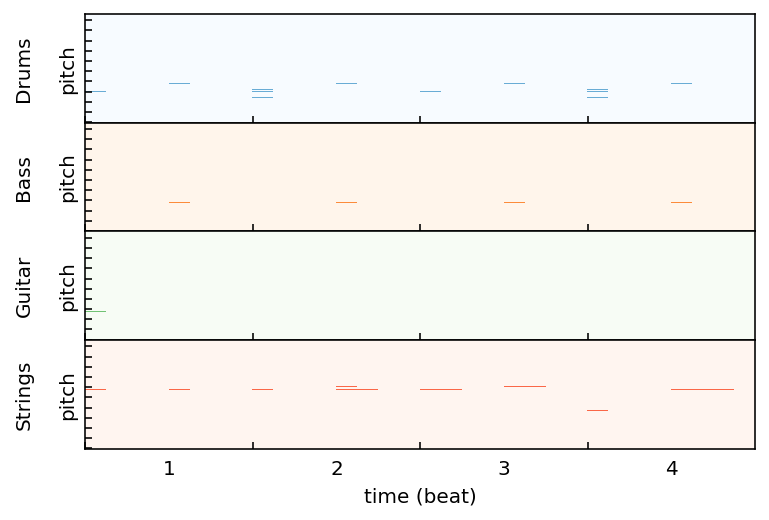

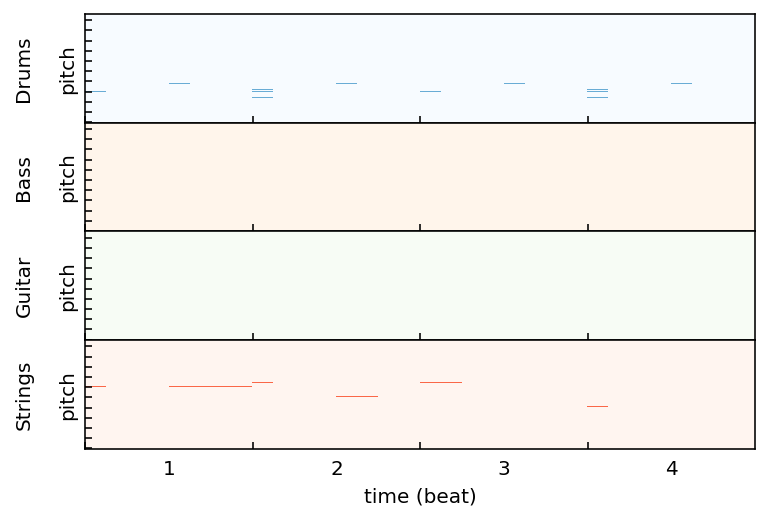

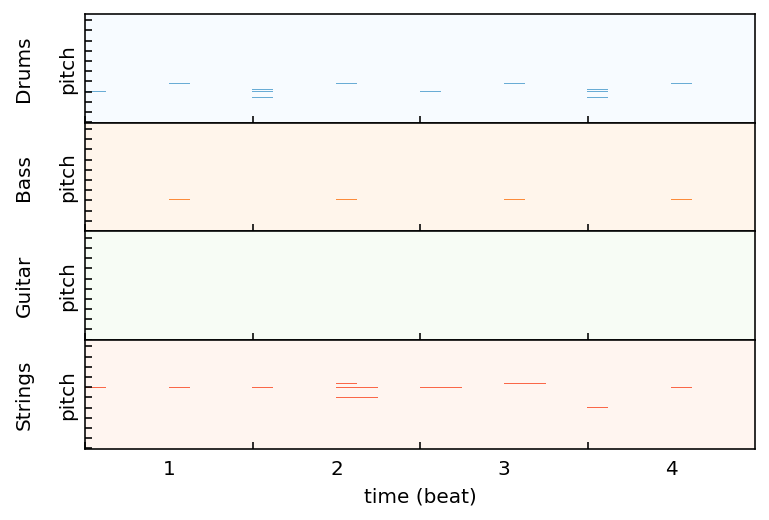

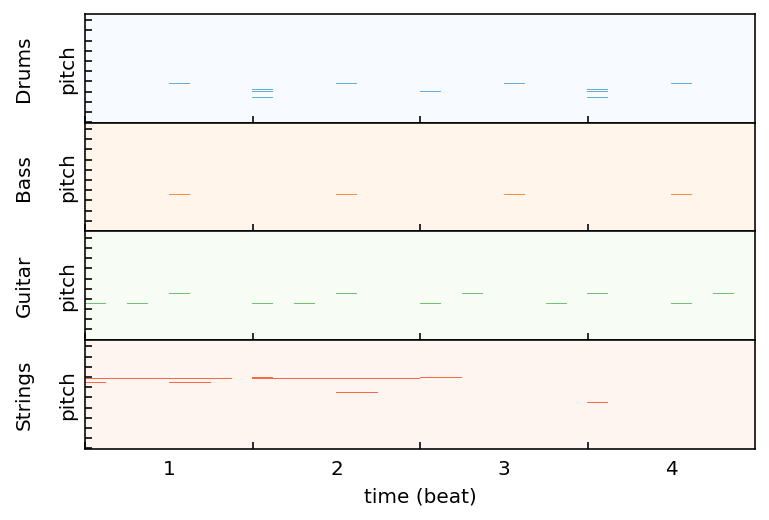

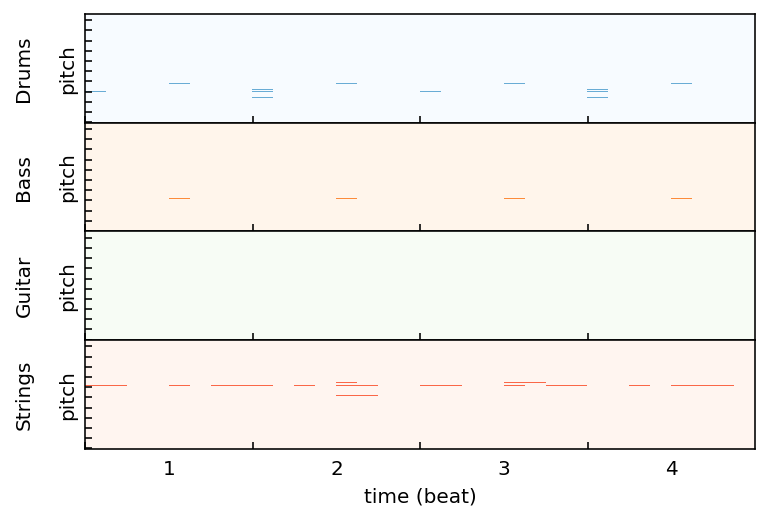

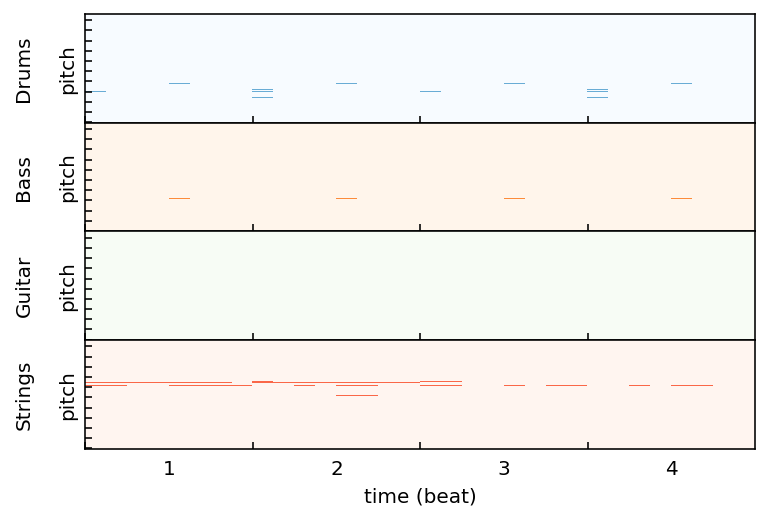

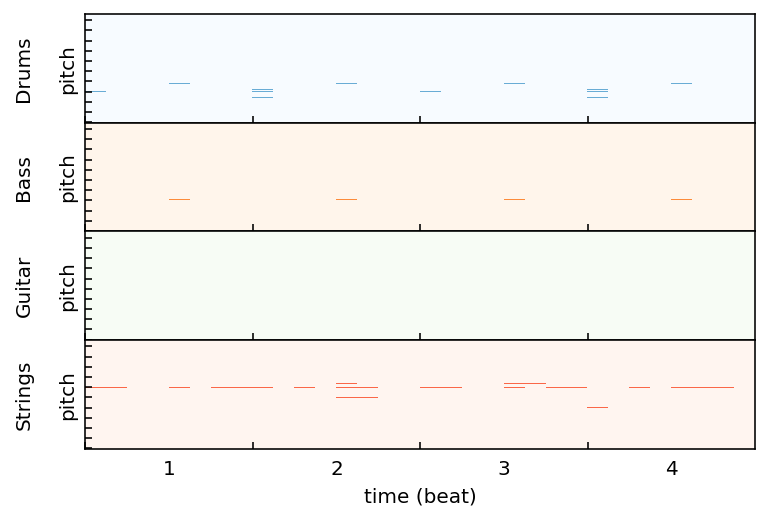

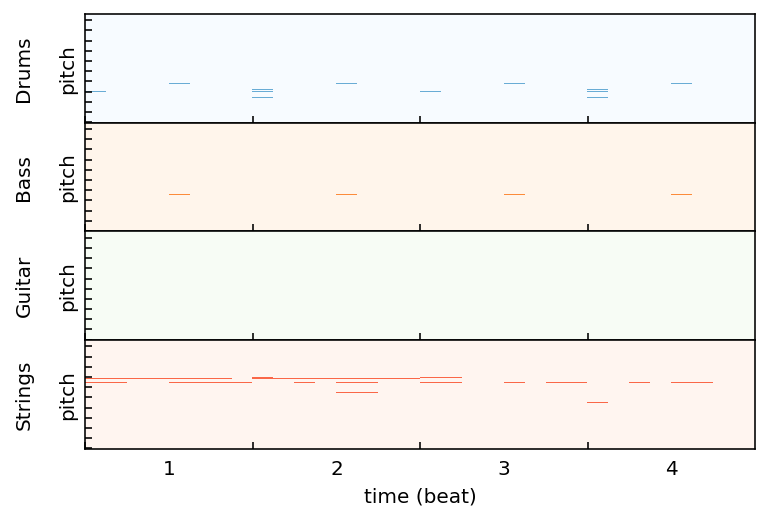

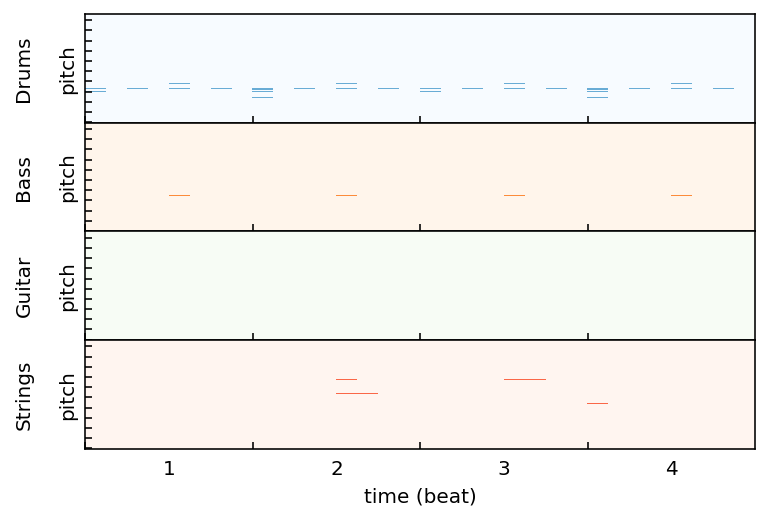

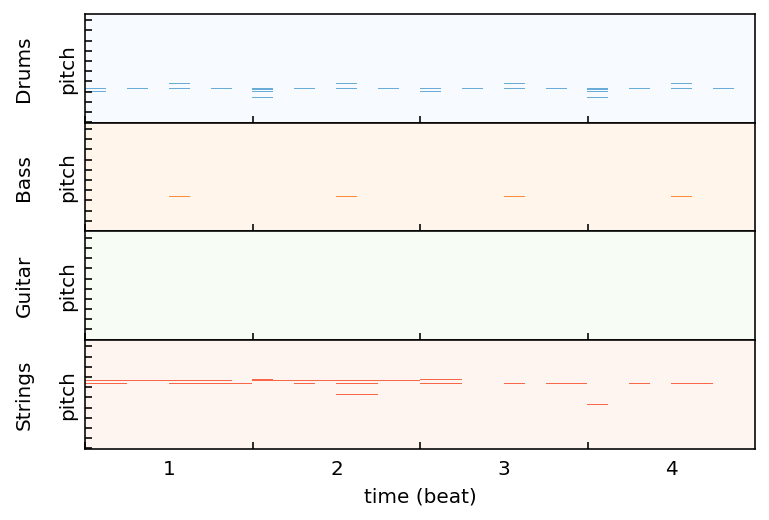

In [88]:
#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.dot(dur, powers).long()
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)

In [58]:
music

Music(metadata=Metadata(schema_version='0.1', title='prova'), resolution=32, tracks=[Track(program=0, is_drum=True, name='Drums', notes=[Note(time=0, pitch=45, duration=1, velocity=64), Note(time=8, pitch=45, duration=1, velocity=64), Note(time=16, pitch=45, duration=1, velocity=64), ...]), Track(program=34, is_drum=False, name='Bass', notes=[Note(time=0, pitch=30, duration=23, velocity=64), Note(time=23, pitch=32, duration=23, velocity=64), Note(time=47, pitch=32, duration=29, velocity=64)]), Track(program=1, is_drum=False, name='Guitar', notes=[Note(time=32, pitch=94, duration=5, velocity=64), Note(time=40, pitch=94, duration=5, velocity=64), Note(time=48, pitch=94, duration=5, velocity=64), ...]), ...])

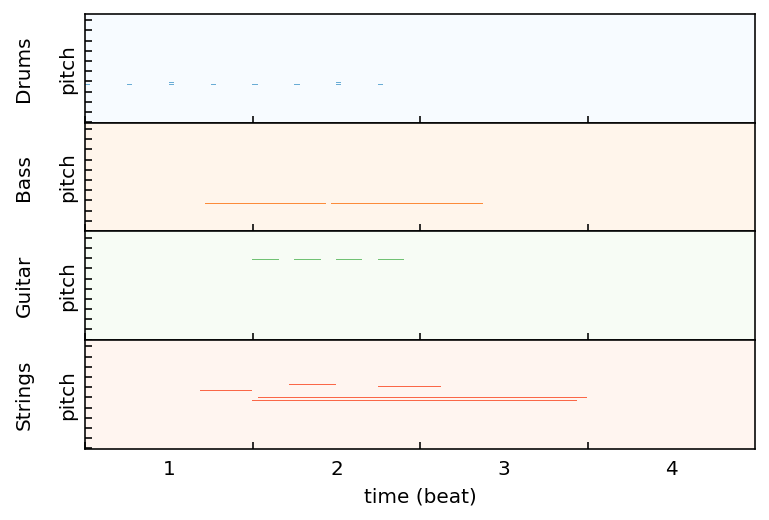

In [60]:
music_path = "data/music/file2.mid"
muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
plt.savefig('file2.png')
muspy.write_midi(music_path, music)

In [ ]:
print(dataset[0][0].size())
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=27, notes=[])
strings = muspy.Track(program=42, notes=[muspy.Note(0, 100, 4, 64), muspy.Note(4, 91, 20, 64)])

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='prova')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)

In [91]:
!ls data/lmd_matched/M/T/O/TRMTOBP128E07822EF/63edabc86c087f07eca448b0edad53c3.mid

63edabc86c087f07eca448b0edad53c3.mid


# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape